In [1]:
import os
import kagglehub

path = kagglehub.dataset_download("fakhrealam9537/leaf-disease-segmentation-dataset")
print("Path to dataset files:", path)

aug_data_dir = os.path.join(path, "aug_data", "aug_data")  
if not os.path.exists(aug_data_dir):
    aug_data_dir = os.path.join(path, "aug_data")  

print("Augmented Data Directory:", aug_data_dir)
if os.path.exists(aug_data_dir):
    print(os.listdir(aug_data_dir))

image_dir = os.path.join(aug_data_dir, "images")
mask_dir = os.path.join(aug_data_dir, "masks")

print("Images Directory Exists:", os.path.exists(image_dir))
print("Masks Directory Exists:", os.path.exists(mask_dir))

if os.path.exists(image_dir):
    image_source_dir = image_dir
else:
    image_source_dir = None
    print("Error: Images directory not found!")

if os.path.exists(mask_dir):
    mask_source_dir = mask_dir
else:
    mask_source_dir = None
    print("Error: Masks directory not found!")

print("Image Source Directory:", image_source_dir)
print("Mask Source Directory:", mask_source_dir)


Path to dataset files: /kaggle/input/leaf-disease-segmentation-dataset
Augmented Data Directory: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data
['images', 'masks']
Images Directory Exists: True
Masks Directory Exists: True
Image Source Directory: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images
Mask Source Directory: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks


FOR RUNNING IT IN KAGGLE -> ENDS HERE

In [2]:
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
from matplotlib.colors import ListedColormap

# image_dir = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/images"
# mask_dir = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/masks"

# image_dir = "D:/THESIS/thesis-dataset/aug_data/aug_data/images"
# mask_dir = "D:/THESIS/thesis-dataset/aug_data/aug_data/masks"

# import kagglehub

image_dir = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images"
mask_dir = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks"

IMG_WIDTH, IMG_HEIGHT = 256, 256
BATCH_SIZE = 32
SEED = 42
torch.manual_seed(SEED)

Unique classes in mask: [ 0 38]


<ipython-input-3-68dcce2ecd5d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ListedColormap(plt.cm.get_cmap("tab20", num_classes).colors)


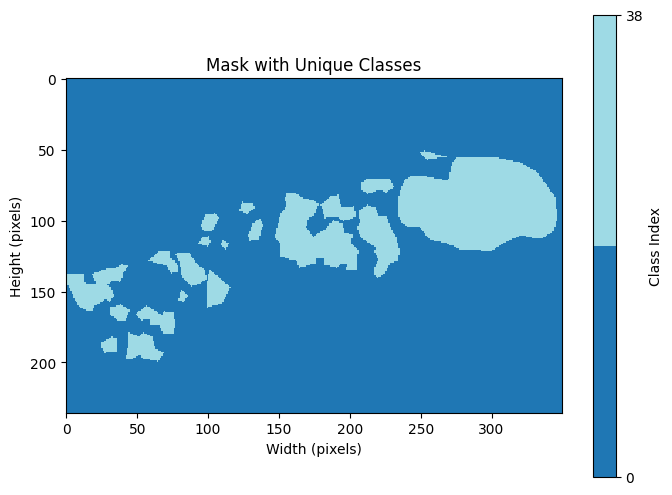

In [3]:
def visualize_label_mapping(mask_path):
    mask = Image.open(mask_path).convert("L")
    mask_array = np.array(mask)

    unique_classes = np.unique(mask_array)
    num_classes = len(unique_classes)
    print(f"Unique classes in mask: {unique_classes}")

    cmap = (
        ListedColormap(plt.cm.get_cmap("tab20", num_classes).colors)
        if num_classes <= 20
        else plt.cm.get_cmap("viridis", num_classes)
    )

    plt.figure(figsize=(8, 6))
    plt.imshow(mask_array, cmap=cmap, interpolation="nearest")
    plt.colorbar(ticks=unique_classes, label="Class Index")
    plt.title("Mask with Unique Classes")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.grid(False)
    plt.show()

    # return num_classes


# custom_mask_path = '/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/masks/00002_0.png'
# custom_mask_path = "D:/THESIS/thesis-dataset/aug_data/aug_data/masks/00002_0.png"
custom_mask_path = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks/00002_0.png"

visualize_label_mapping(custom_mask_path)

In [4]:
def find_num_classes(mask_dir):
    unique_classes = set()
    for mask_filename in os.listdir(mask_dir):
        if mask_filename.endswith((".png")):
            mask_path = os.path.join(mask_dir, mask_filename)
            mask = Image.open(mask_path).convert("L")
            mask_array = np.array(mask)
            unique_classes.update(np.unique(mask_array))

    num_classes = len(unique_classes)
    print(f"Unique classes across all masks: {sorted(unique_classes)}")
    print(f"Number of classes: {num_classes}")
    return num_classes


mask_directory = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks"
num_classes = find_num_classes(mask_directory)

Unique classes across all masks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
Number of classes: 39


In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )

        self.transform_mask = transforms.Compose(
            [
                transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
            ]
        )

        unique_classes = set()
        for mask_path in self.mask_files:
            mask = np.array(
                Image.open(os.path.join(self.mask_dir, mask_path)).convert("L")
            )
            unique_classes.update(np.unique(mask))
        self.class_map = {val: idx for idx, val in enumerate(sorted(unique_classes))}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        image = self.transform(image)
        mask = torch.from_numpy(
            np.array(mask.resize((IMG_WIDTH, IMG_HEIGHT), Image.Resampling.NEAREST))
        ).long()

        mask = np.vectorize(self.class_map.get)(mask)
        mask = torch.from_numpy(mask).long()

        return image, mask


dataset = SegmentationDataset(image_dir, mask_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Total Dataset: {len(dataset)}")
print(f"Train Size: {len(train_dataset)}")
print(f"Validation Size: {len(val_dataset)}")
print(f"Test Size: {len(test_dataset)}")

Total Dataset: 2940
Train Size: 2058
Validation Size: 441
Test Size: 441


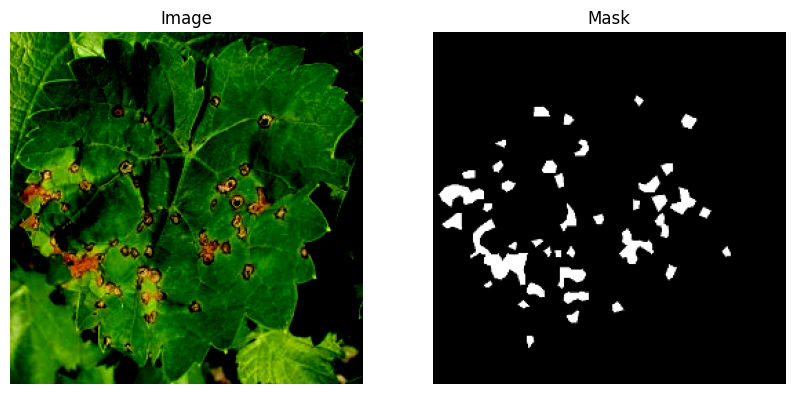

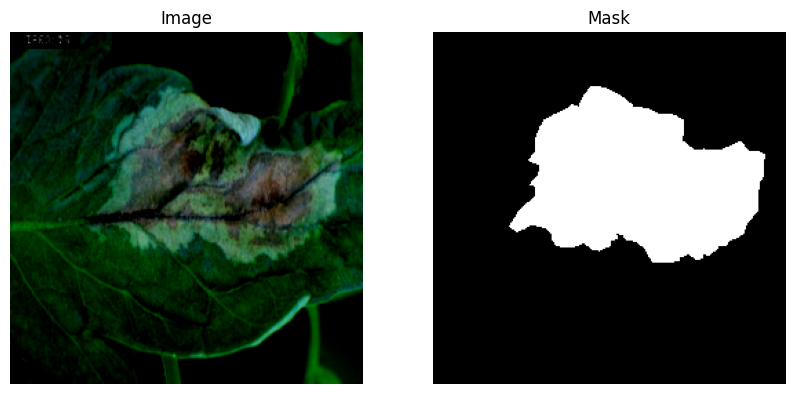

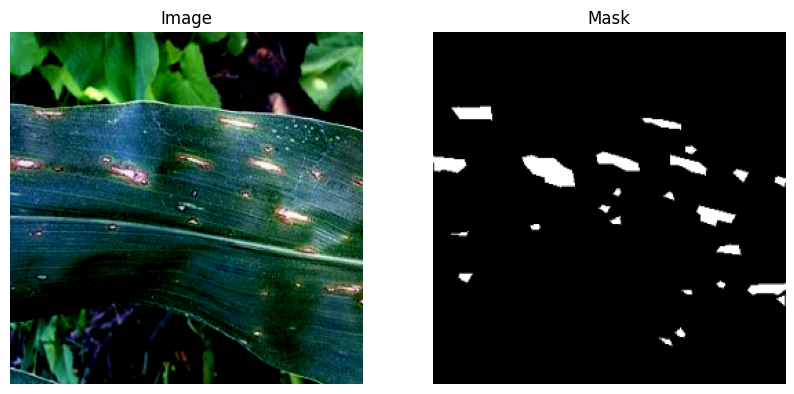

In [6]:
def show_data_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, mask = dataset[i]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Image")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")
        plt.show()


show_data_samples(train_dataset, num_samples=3)

In [7]:
def count_rgb_images(split_dataset):
    rgb_count = 0
    non_rgb_count = 0

    for idx in range(len(split_dataset)):
        image, _ = split_dataset[idx]
        if image.shape[0] == 3:
            rgb_count += 1
        else:
            non_rgb_count += 1

    return rgb_count, non_rgb_count


train_rgb, train_non_rgb = count_rgb_images(train_dataset)
val_rgb, val_non_rgb = count_rgb_images(val_dataset)
test_rgb, test_non_rgb = count_rgb_images(test_dataset)

print(f"Train Dataset: {train_rgb} RGB, {train_non_rgb} Non-RGB")
print(f"Validation Dataset: {val_rgb} RGB, {val_non_rgb} Non-RGB")
print(f"Test Dataset: {test_rgb} RGB, {test_non_rgb} Non-RGB")

Train Dataset: 2058 RGB, 0 Non-RGB
Validation Dataset: 441 RGB, 0 Non-RGB
Test Dataset: 441 RGB, 0 Non-RGB


In [8]:
def count_mask_types(mask_dir):
    binary_count = 0
    multiclass_count = 0

    mask_files = os.listdir(mask_dir)
    if not mask_files:
        print(f"No files found in the directory: {mask_dir}")
        return

    for mask_file in mask_files:
        mask_path = os.path.join(mask_dir, mask_file)

        try:
            mask = np.array(Image.open(mask_path))
            unique_values = np.unique(mask)

            if len(unique_values) == 2:
                binary_count += 1
            else:
                multiclass_count += 1
        except Exception as e:
            print(f"Error processing {mask_file}: {e}")

    print(f"Number of Binary Masks: {binary_count}")
    print(f"Number of Multi-class Masks: {multiclass_count}")
    print(f"Total Masks: {binary_count + multiclass_count}")
    print(f"Percentage of Binary Masks: {(binary_count / len(mask_files)) * 100:.2f}%")
    print(
        f"Percentage of Multi-class Masks: {(multiclass_count / len(mask_files)) * 100:.2f}%"
    )


count_mask_types(mask_dir)

Number of Binary Masks: 1560
Number of Multi-class Masks: 1380
Total Masks: 2940
Percentage of Binary Masks: 53.06%
Percentage of Multi-class Masks: 46.94%


In [9]:
# analyze_class_distribution(train_dataset) only processes masks included in the train_dataset [2058] split.

def analyze_class_distribution(dataset):
    class_counts = Counter()

    for _, mask in dataset:
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        class_counts.update(dict(zip(unique, counts)))

    print("Class distribution in dataset:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} pixels")


analyze_class_distribution(train_dataset)

Class distribution in dataset:
Class 0: 112660552 pixels
Class 1: 30934 pixels
Class 2: 35779 pixels
Class 3: 26134 pixels
Class 4: 28654 pixels
Class 5: 31963 pixels
Class 6: 22372 pixels
Class 7: 20821 pixels
Class 8: 29667 pixels
Class 9: 23683 pixels
Class 10: 22753 pixels
Class 11: 26288 pixels
Class 12: 19756 pixels
Class 13: 22044 pixels
Class 14: 30222 pixels
Class 15: 19905 pixels
Class 16: 18310 pixels
Class 17: 26664 pixels
Class 18: 19412 pixels
Class 19: 28207 pixels
Class 20: 27403 pixels
Class 21: 19213 pixels
Class 22: 20684 pixels
Class 23: 29673 pixels
Class 24: 19451 pixels
Class 25: 20612 pixels
Class 26: 26015 pixels
Class 27: 21362 pixels
Class 28: 21351 pixels
Class 29: 29338 pixels
Class 30: 20395 pixels
Class 31: 29198 pixels
Class 32: 23824 pixels
Class 33: 28311 pixels
Class 34: 34464 pixels
Class 35: 24503 pixels
Class 36: 26583 pixels
Class 37: 43376 pixels
Class 38: 21263212 pixels


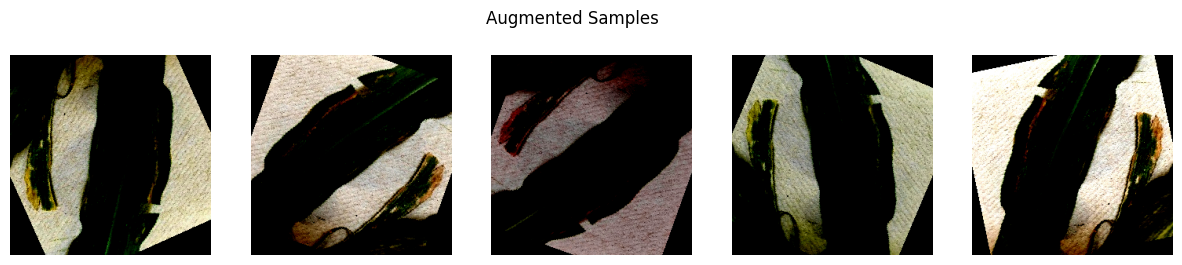

In [10]:
augmentation_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)


def visualize_augmentations(image_path, num_augmentations=5):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(15, 3))
    for i in range(num_augmentations):
        augmented_image = augmentation_transform(image)
        plt.subplot(1, num_augmentations, i + 1)
        plt.imshow(augmented_image.permute(1, 2, 0).numpy())
        plt.axis("off")
    plt.suptitle("Augmented Samples")
    plt.show()


visualize_augmentations(os.path.join(image_dir, os.listdir(image_dir)[0]))

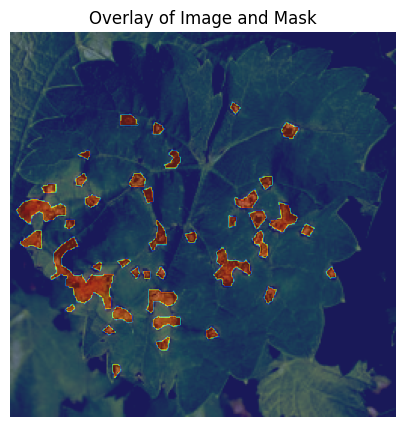

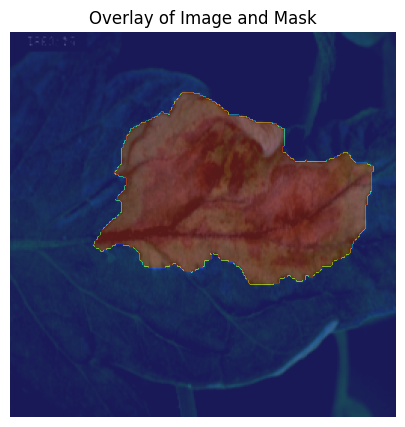

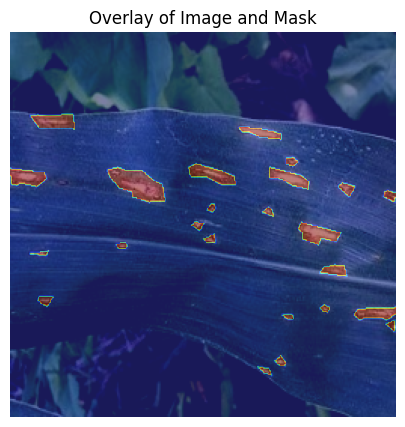

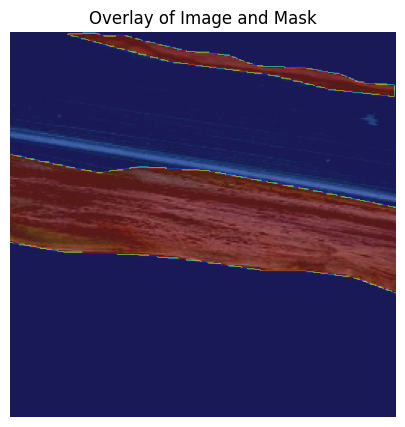

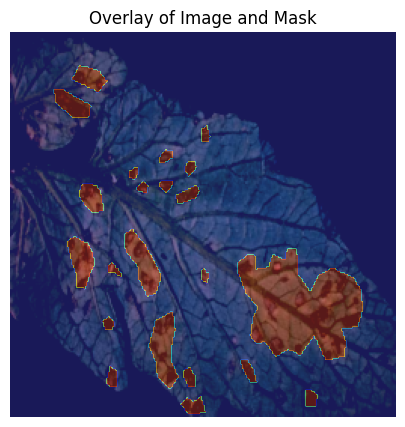

In [11]:
def overlay_masks(image, mask):
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(image_np, alpha=0.8)
    plt.imshow(mask_np, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("Overlay of Image and Mask")
    plt.show()


for i in range(5):
    image, mask = train_dataset[i]
    overlay_masks(image, mask)

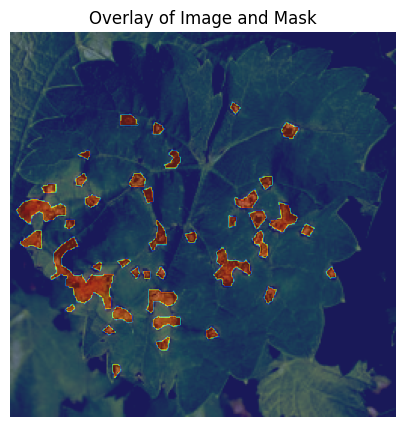

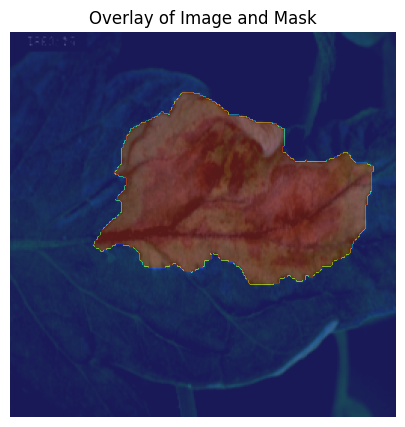

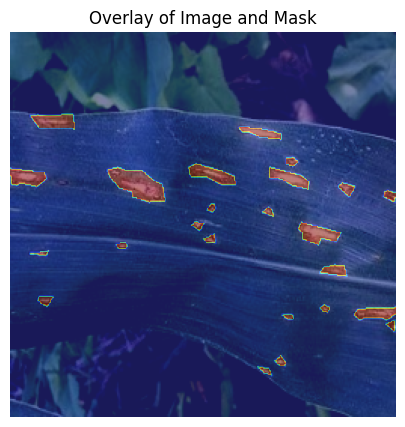

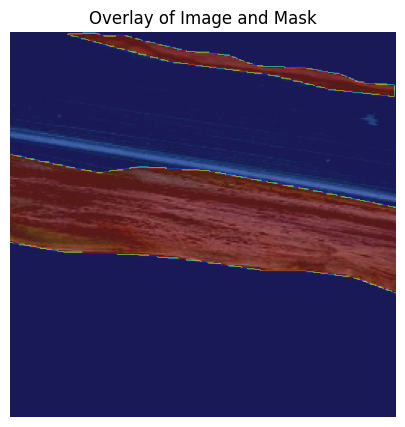

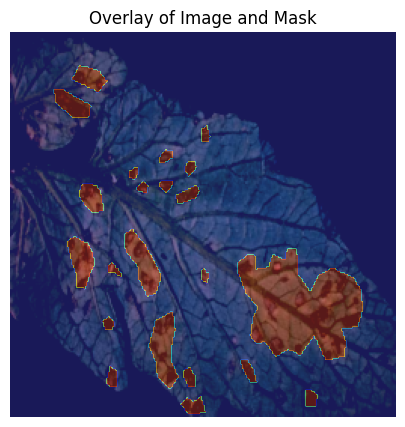

In [12]:
def overlay_masks(image, mask):
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(image_np, alpha=0.8)
    plt.imshow(mask_np, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("Overlay of Image and Mask")
    plt.show()


for i in range(5):
    image, mask = train_dataset[i]
    overlay_masks(image, mask)

In [14]:
def dataset_summary(dataset):
    total_images = len(dataset)
    heights, widths = [], []
    class_counts = Counter()

    for image, mask in dataset:
        heights.append(image.shape[1])
        widths.append(image.shape[2])
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        class_counts.update(dict(zip(unique, counts)))

    print(f"Total Images: {total_images}")
    print(
        f"Image Dimensions: Min={min(heights)}x{min(widths)}, Max={max(heights)}x{max(widths)}"
    )


dataset_summary(train_dataset)

Total Images: 2058
Image Dimensions: Min=256x256, Max=256x256


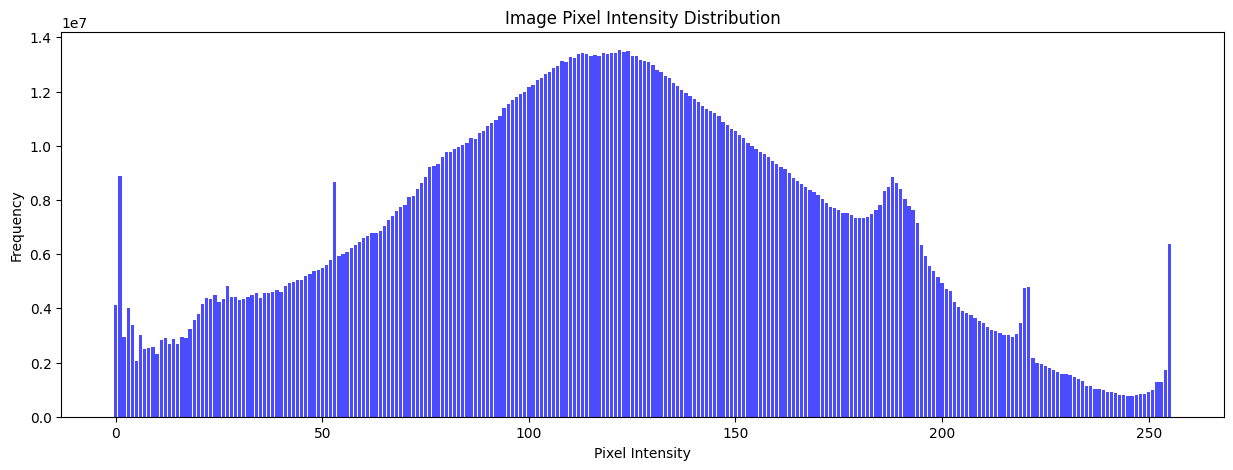

In [16]:
def pixel_intensity_analysis(image_dir):
    image_intensity_counts = np.zeros(256)

    for image_file in sorted(os.listdir(image_dir)):
        image_path = os.path.join(image_dir, image_file)
        image = np.array(Image.open(image_path).convert("L"))

        unique, counts = np.unique(image, return_counts=True)
        image_intensity_counts[unique] += counts

    plt.figure(figsize=(15, 5))
    plt.bar(range(256), image_intensity_counts, color="blue", alpha=0.7)
    plt.title("Image Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()


pixel_intensity_analysis(image_dir)

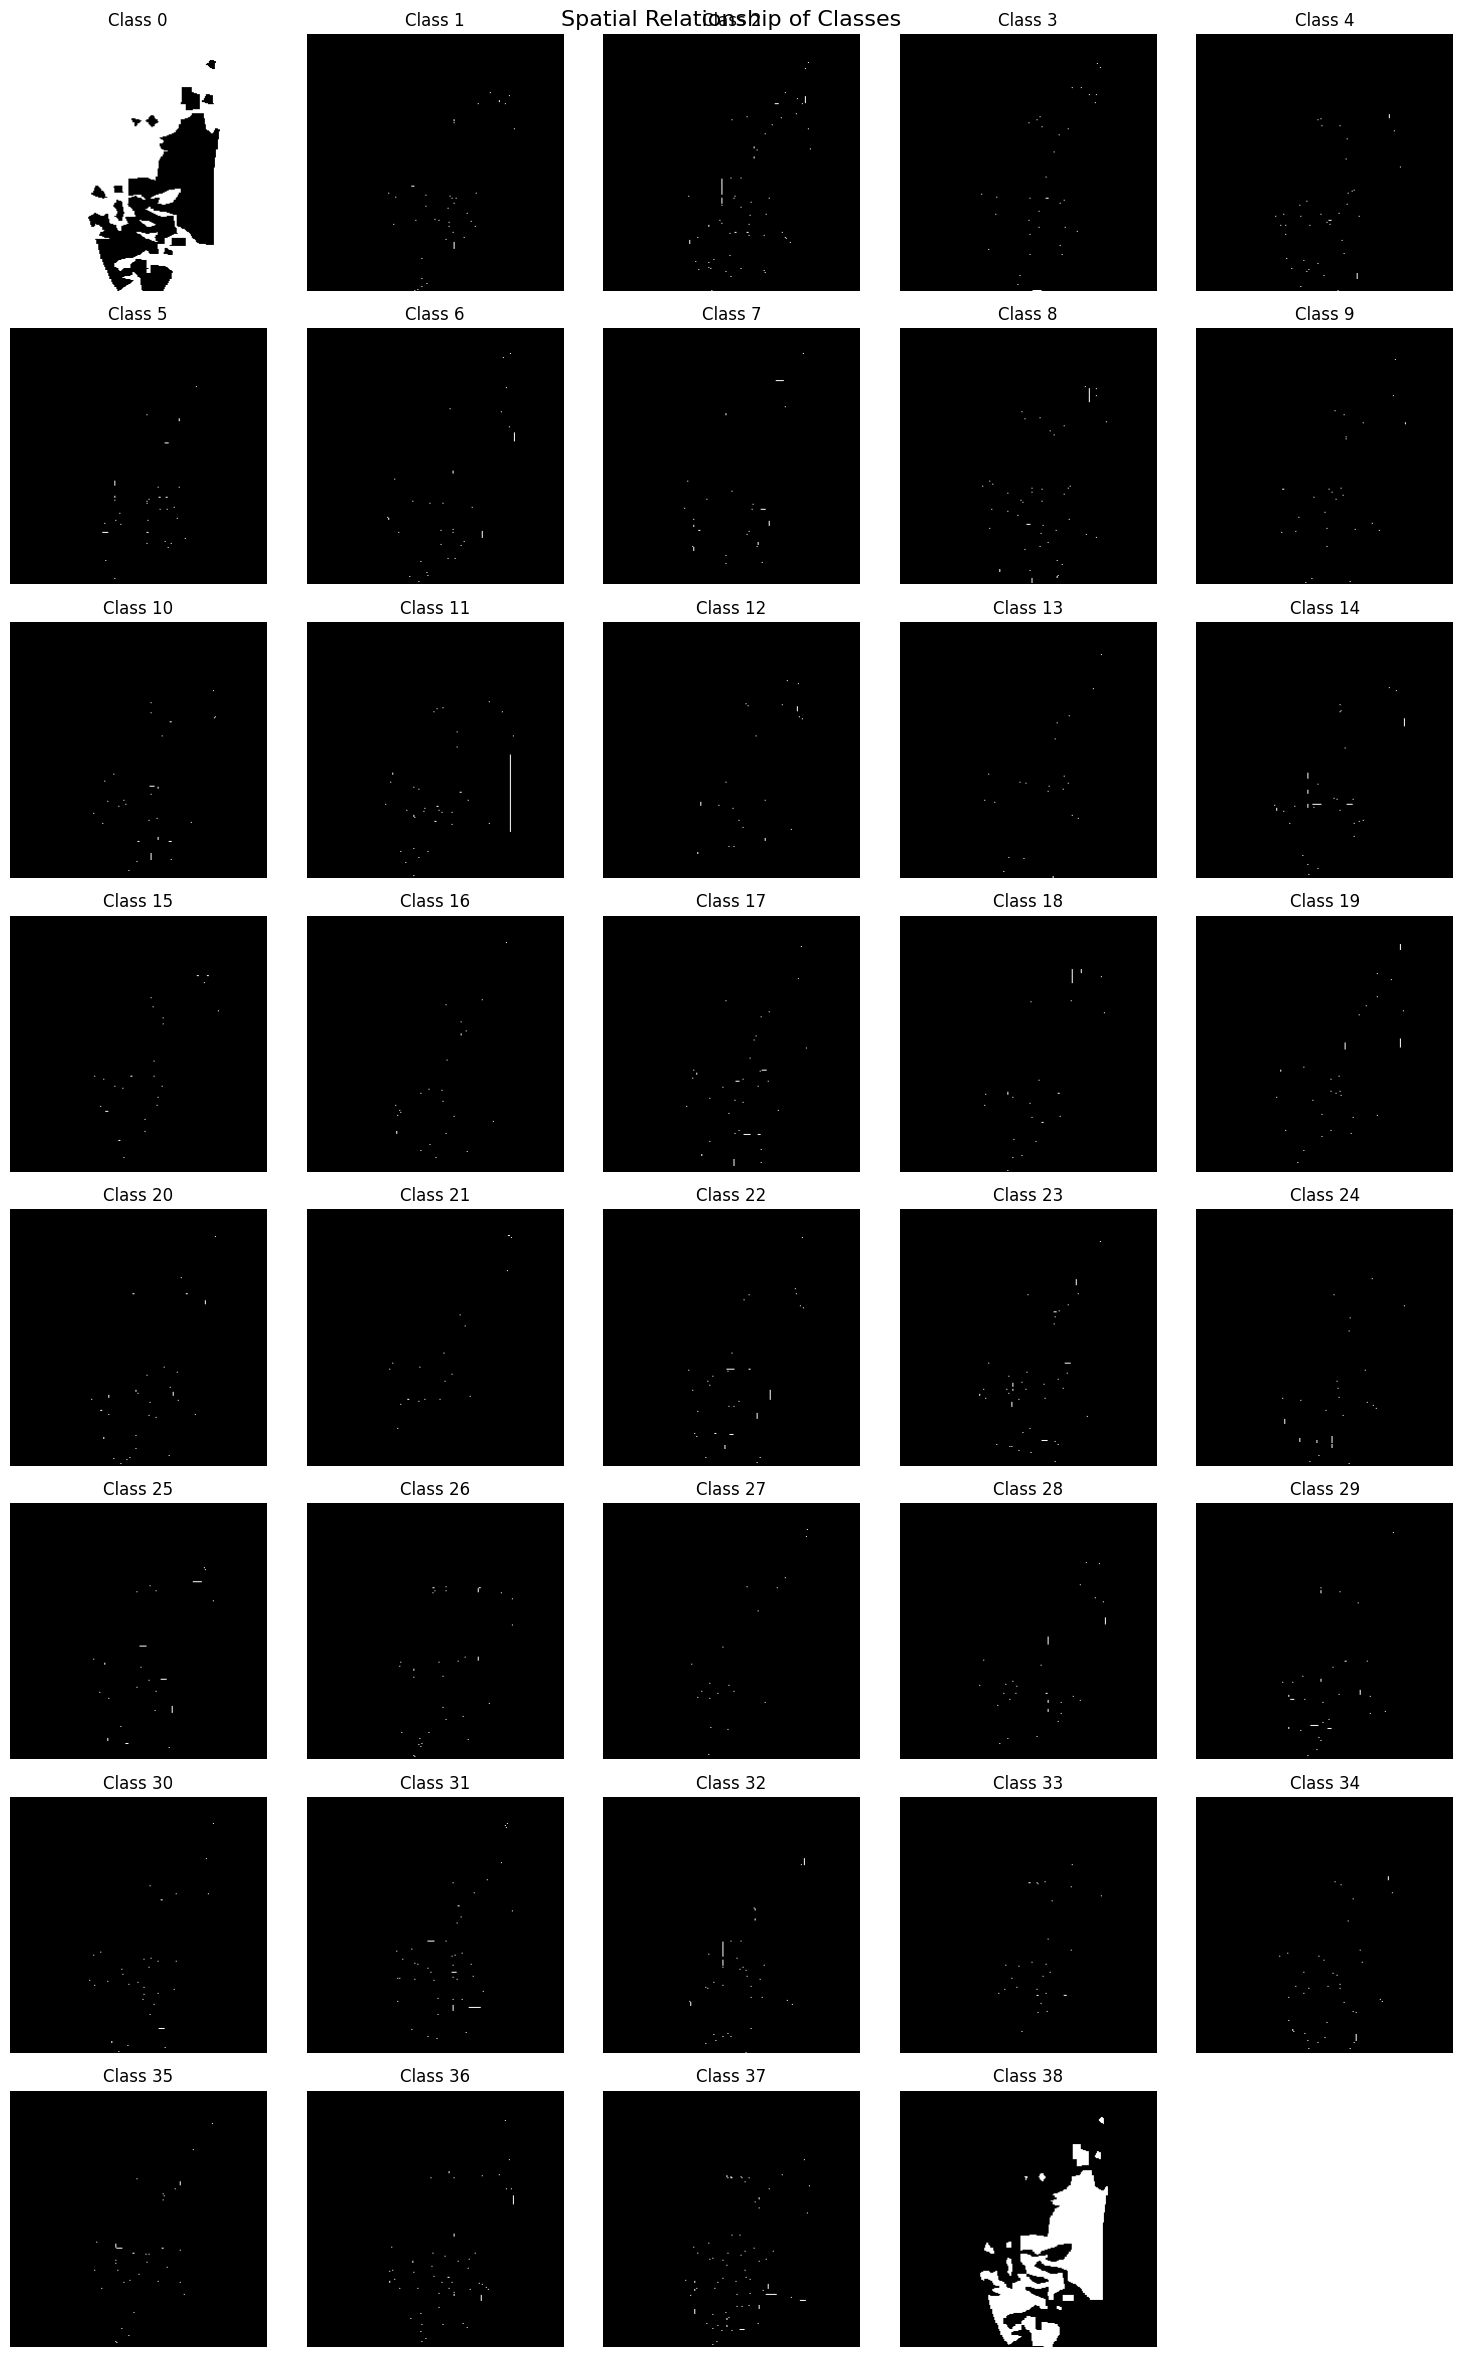

In [17]:
def visualize_class_relationships(mask_path):
    mask = np.array(Image.open(mask_path).convert("L"))
    unique_classes = np.unique(mask)

    num_classes = len(unique_classes)
    cols = 5
    rows = (num_classes + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))

    for idx, cls in enumerate(unique_classes):
        binary_mask = (mask == cls).astype(np.uint8)
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(binary_mask, cmap="gray")
        plt.title(f"Class {cls}")
        plt.axis("off")

    plt.suptitle("Spatial Relationship of Classes", fontsize=16)
    plt.tight_layout()
    plt.show()


mask_example_path = os.path.join(mask_dir, os.listdir(mask_dir)[0])
visualize_class_relationships(mask_example_path)

Class Pixel Counts:
Class 0: 1538658705 pixels
Class 38: 270806410 pixels
Class 1: 44710 pixels
Class 2: 52005 pixels
Class 3: 37915 pixels
Class 4: 41095 pixels
Class 5: 45935 pixels
Class 6: 32470 pixels
Class 7: 30120 pixels
Class 8: 42660 pixels
Class 9: 34140 pixels
Class 10: 32135 pixels
Class 11: 38555 pixels
Class 12: 28490 pixels
Class 13: 31520 pixels
Class 14: 43465 pixels
Class 15: 28800 pixels
Class 16: 26825 pixels
Class 17: 38945 pixels
Class 18: 27995 pixels
Class 19: 38560 pixels
Class 20: 39465 pixels
Class 21: 27635 pixels
Class 22: 30130 pixels
Class 23: 43050 pixels
Class 24: 27640 pixels
Class 25: 29625 pixels
Class 26: 37140 pixels
Class 27: 31485 pixels
Class 28: 30225 pixels
Class 29: 42650 pixels
Class 30: 28985 pixels
Class 31: 41445 pixels
Class 32: 33855 pixels
Class 33: 41125 pixels
Class 34: 49135 pixels
Class 35: 35525 pixels
Class 36: 38420 pixels
Class 37: 61745 pixels


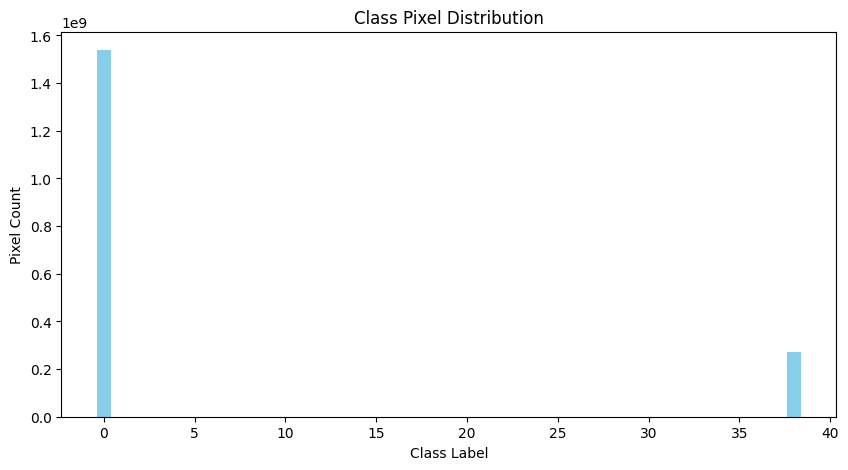

In [18]:
# check_class_imbalance(mask_dir) analyzes all masks in the mask_dir.

from collections import Counter


def check_class_imbalance(mask_dir):
    class_counts = Counter()
    for mask_file in sorted(os.listdir(mask_dir)):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = np.array(Image.open(mask_path).convert("L"))
        unique, counts = np.unique(mask, return_counts=True)
        class_counts.update(dict(zip(unique, counts)))

    print("Class Pixel Counts:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} pixels")

    classes, counts = zip(*sorted(class_counts.items()))
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color="skyblue")
    plt.xlabel("Class Label")
    plt.ylabel("Pixel Count")
    plt.title("Class Pixel Distribution")
    plt.show()


check_class_imbalance(mask_dir)

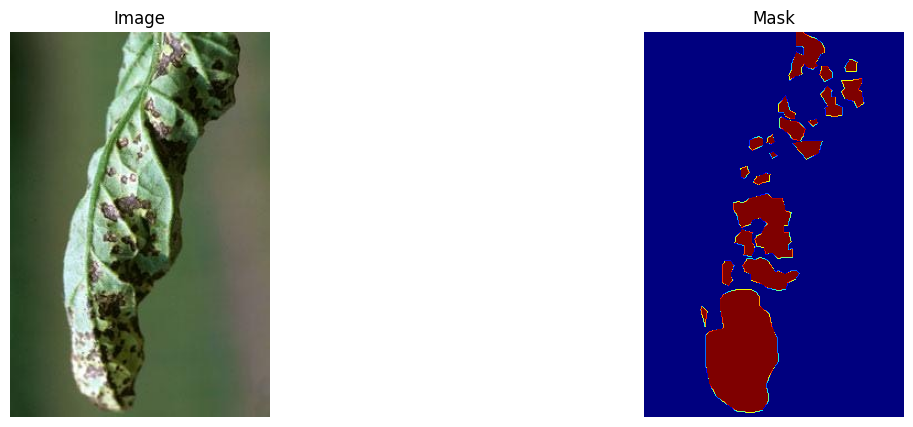

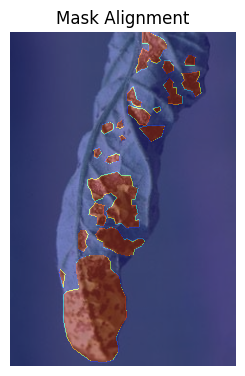

In [19]:
def check_mask_alignment(image_path, mask_path):
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="jet")
    plt.title("Mask")
    plt.axis("off")
    plt.show()

    plt.subplot(1, 2, 2)
    plt.imshow(image, alpha=0.8)
    plt.imshow(mask, cmap="jet", alpha=0.5)
    plt.title("Mask Alignment")
    plt.axis("off")
    plt.show()


# custom_image_path = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/images/00002_1.jpg"
# custom_mask_path = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/masks/00002_1.png"

# custom_image_path = "D:/THESIS/thesis-dataset/aug_data/aug_data/images/00002_1.jpg"
# custom_mask_path = "D:/THESIS/thesis-dataset/aug_data/aug_data/masks/00002_1.png"

custom_image_path = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00002_1.jpg"
custom_mask_path = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks/00002_1.png"

check_mask_alignment(custom_image_path, custom_mask_path)

# UNET

In [20]:
# UNET-PARTS

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/500


Validation: 100%|██████████| 28/28 [00:55<00:00,  1.98s/it]

Train Loss: 2.9417, Train IoU: 0.0227 | Val Loss: 2.4071, Val IoU: 0.0252
Model saved as saved_models/UNet_epoch_1.pth
Metrics saved as saved_models/metrics_epoch_1.csv


/kaggle/working/saved_models/UNet_epoch_1.pth

/kaggle/working/saved_models/metrics_epoch_1.csv

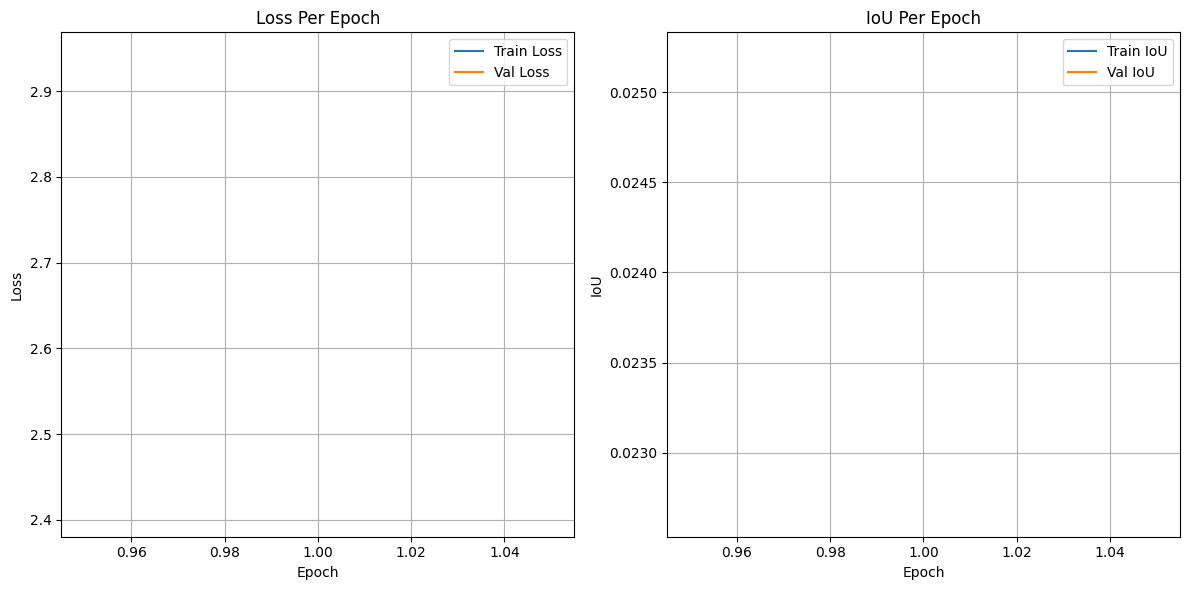

Epoch 2/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.94s/it]

Train Loss: 2.2800, Train IoU: 0.0246 | Val Loss: 2.1829, Val IoU: 0.0206
Model saved as saved_models/UNet_epoch_2.pth
Metrics saved as saved_models/metrics_epoch_2.csv


/kaggle/working/saved_models/UNet_epoch_2.pth

/kaggle/working/saved_models/metrics_epoch_2.csv

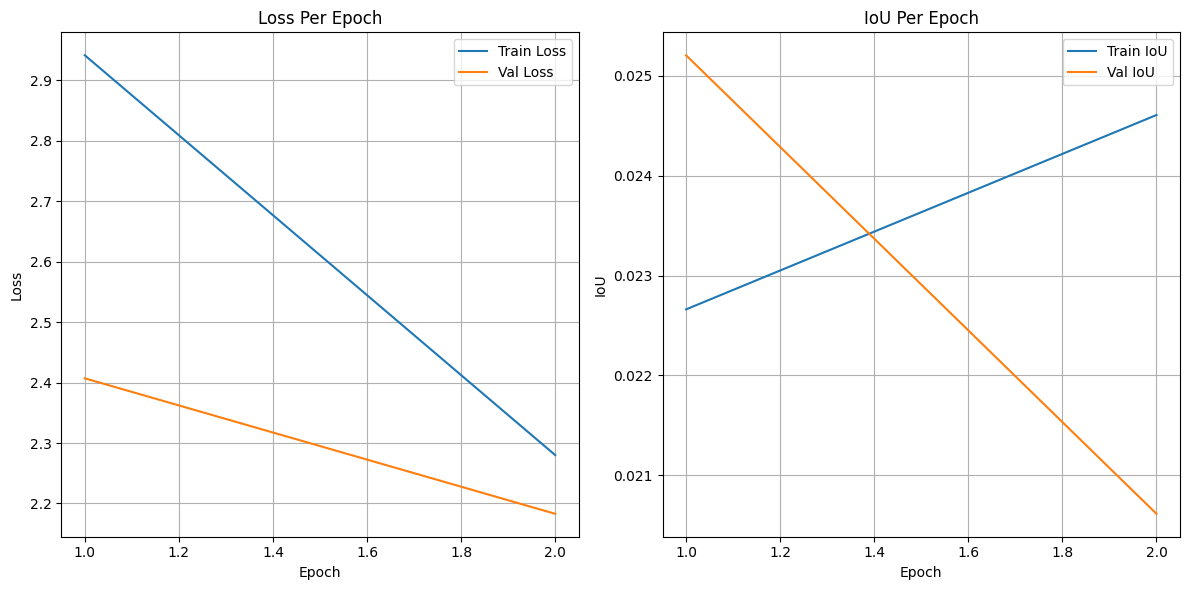

Epoch 3/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.94s/it]

Train Loss: 1.7873, Train IoU: 0.0253 | Val Loss: 1.6156, Val IoU: 0.0249
Model saved as saved_models/UNet_epoch_3.pth
Metrics saved as saved_models/metrics_epoch_3.csv


/kaggle/working/saved_models/UNet_epoch_3.pth

/kaggle/working/saved_models/metrics_epoch_3.csv

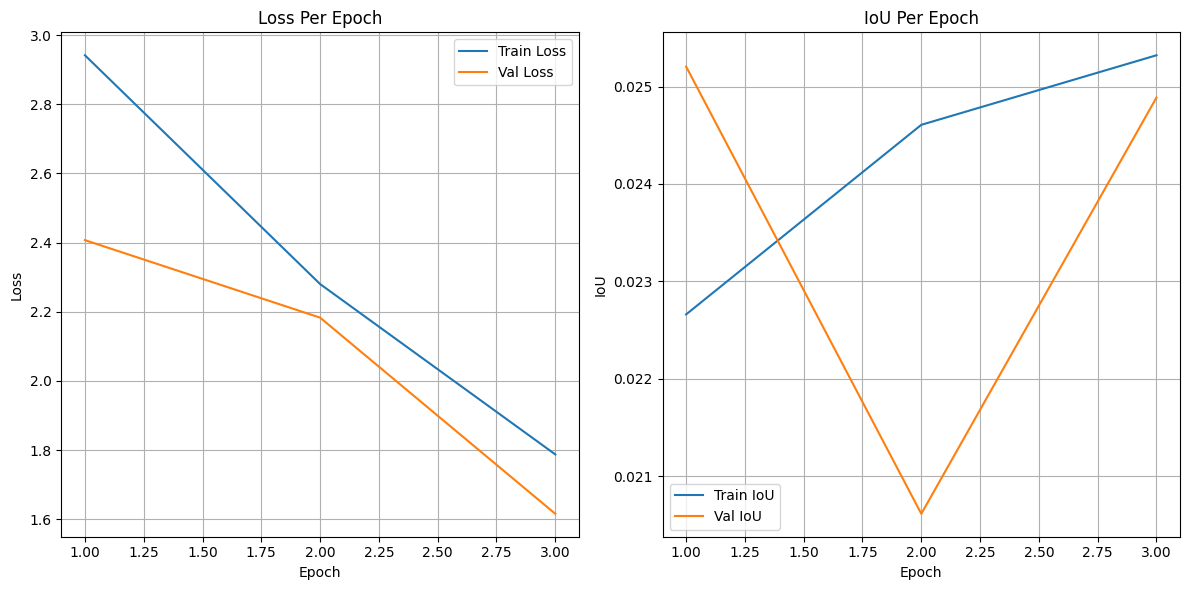

Epoch 4/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.95s/it]

Train Loss: 1.3749, Train IoU: 0.0270 | Val Loss: 1.2440, Val IoU: 0.0271
Model saved as saved_models/UNet_epoch_4.pth
Metrics saved as saved_models/metrics_epoch_4.csv


/kaggle/working/saved_models/UNet_epoch_4.pth

/kaggle/working/saved_models/metrics_epoch_4.csv

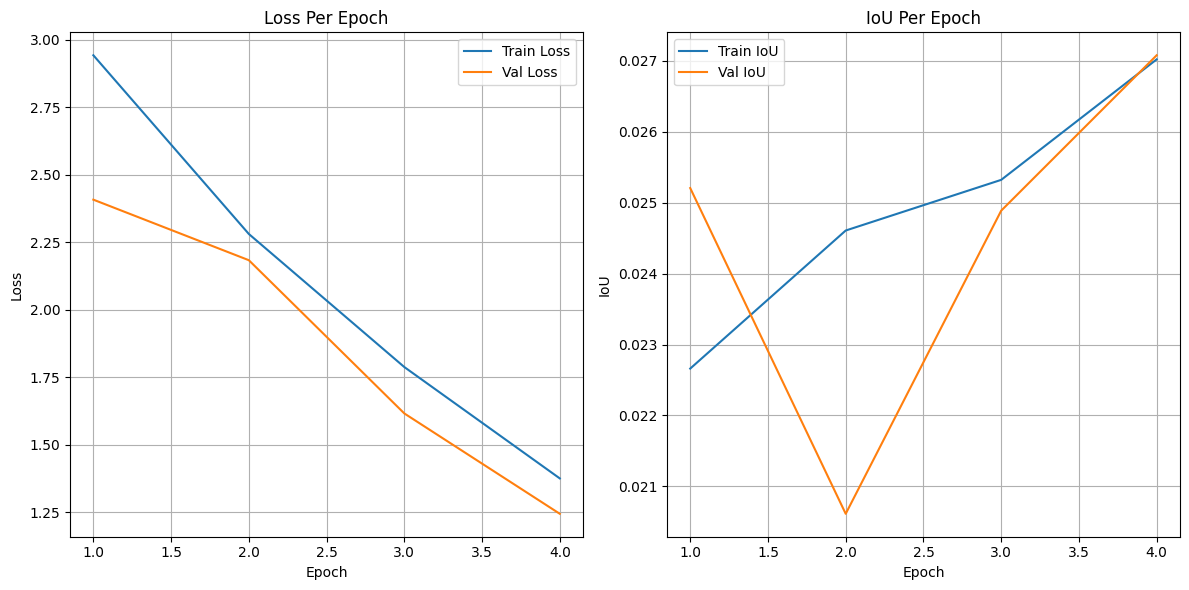

Epoch 5/500


Validation: 100%|██████████| 28/28 [00:53<00:00,  1.93s/it]

Train Loss: 1.0106, Train IoU: 0.0318 | Val Loss: 0.8393, Val IoU: 0.0343
Model saved as saved_models/UNet_epoch_5.pth
Metrics saved as saved_models/metrics_epoch_5.csv


/kaggle/working/saved_models/UNet_epoch_5.pth

/kaggle/working/saved_models/metrics_epoch_5.csv

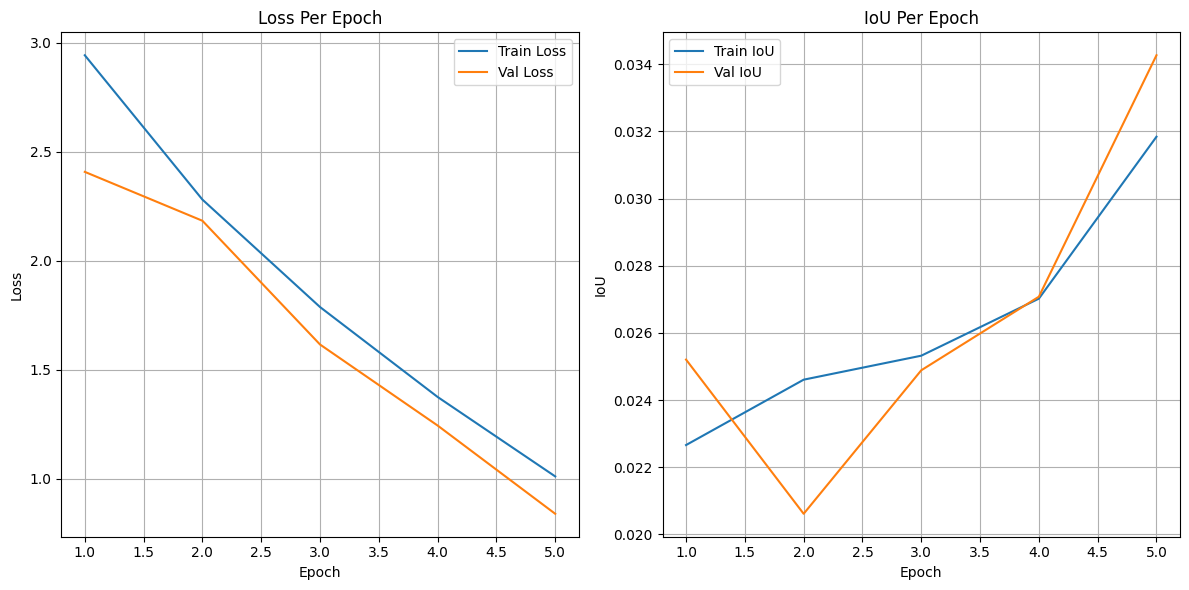

Epoch 6/500


Validation: 100%|██████████| 28/28 [00:53<00:00,  1.92s/it]

Train Loss: 0.7198, Train IoU: 0.0351 | Val Loss: 0.6186, Val IoU: 0.0365
Model saved as saved_models/UNet_epoch_6.pth
Metrics saved as saved_models/metrics_epoch_6.csv


/kaggle/working/saved_models/UNet_epoch_6.pth

/kaggle/working/saved_models/metrics_epoch_6.csv

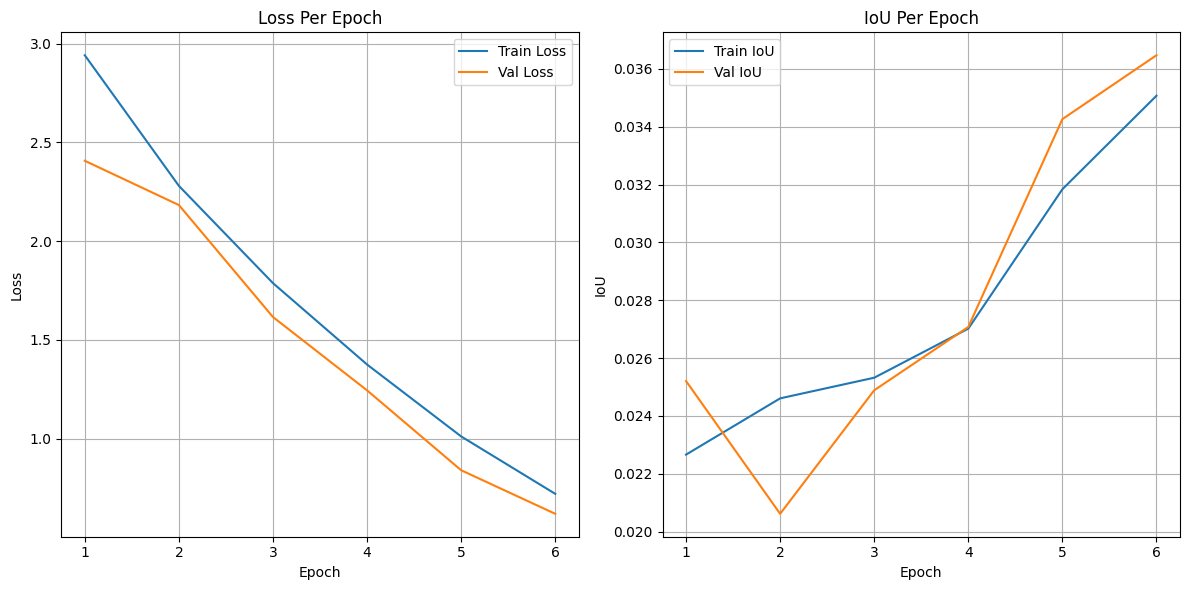

Epoch 7/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.94s/it]

Train Loss: 0.5438, Train IoU: 0.0366 | Val Loss: 0.4681, Val IoU: 0.0374
Model saved as saved_models/UNet_epoch_7.pth
Metrics saved as saved_models/metrics_epoch_7.csv


/kaggle/working/saved_models/UNet_epoch_7.pth

/kaggle/working/saved_models/metrics_epoch_7.csv

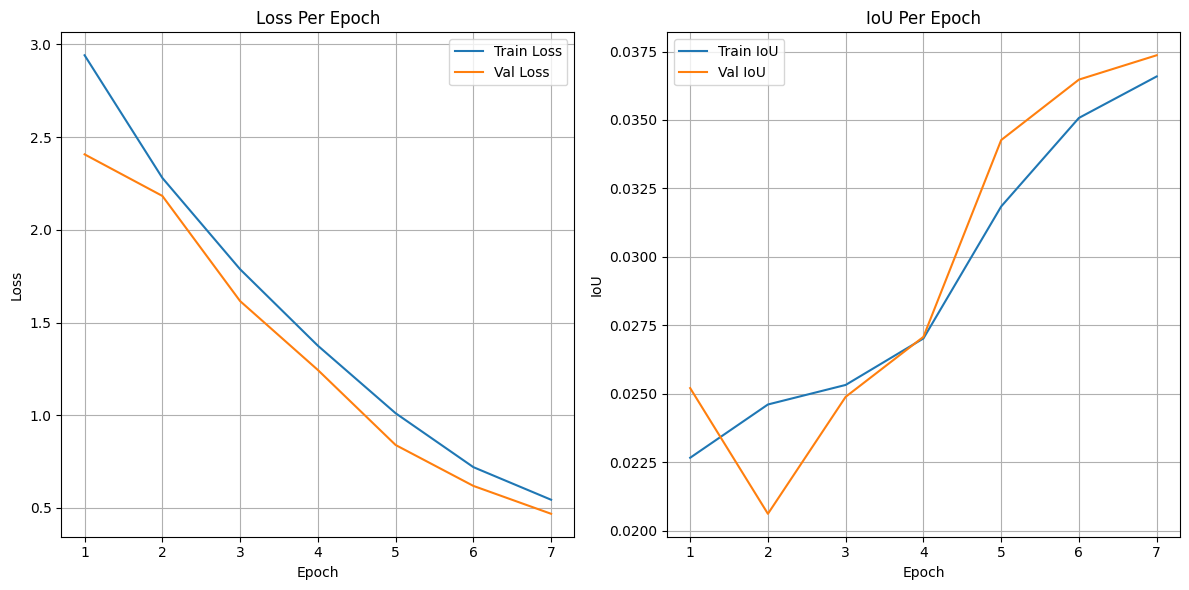

Epoch 8/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.94s/it]

Train Loss: 0.4338, Train IoU: 0.0393 | Val Loss: 0.3954, Val IoU: 0.0362
Model saved as saved_models/UNet_epoch_8.pth
Metrics saved as saved_models/metrics_epoch_8.csv


/kaggle/working/saved_models/UNet_epoch_8.pth

/kaggle/working/saved_models/metrics_epoch_8.csv

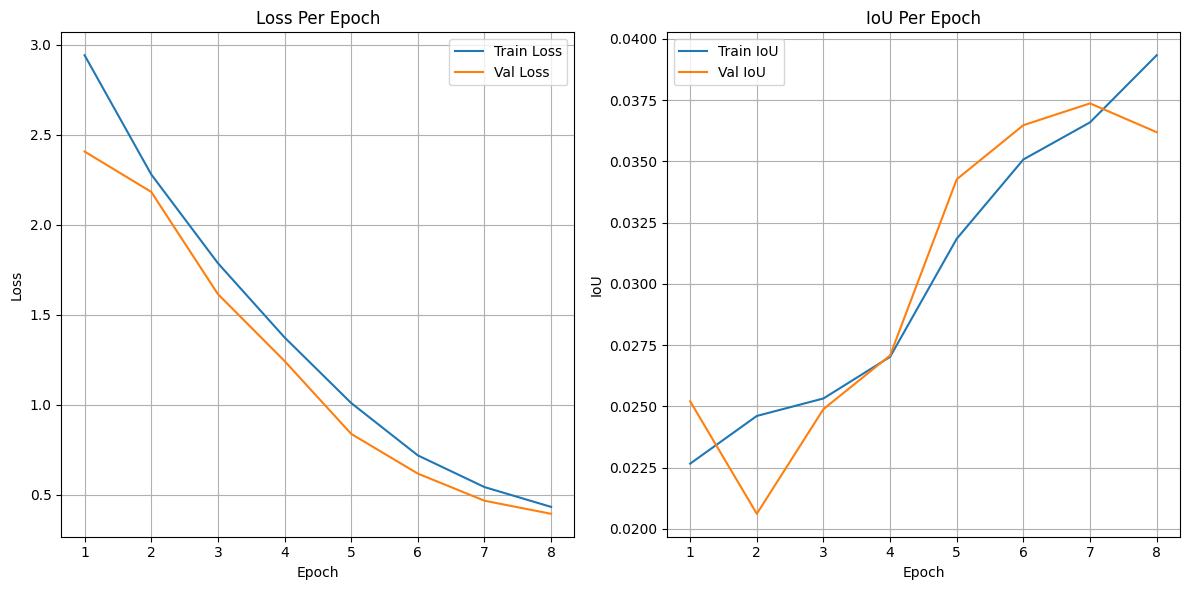

Epoch 9/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.96s/it]

Train Loss: 0.3631, Train IoU: 0.0380 | Val Loss: 0.3444, Val IoU: 0.0372
Model saved as saved_models/UNet_epoch_9.pth
Metrics saved as saved_models/metrics_epoch_9.csv


/kaggle/working/saved_models/UNet_epoch_9.pth

/kaggle/working/saved_models/metrics_epoch_9.csv

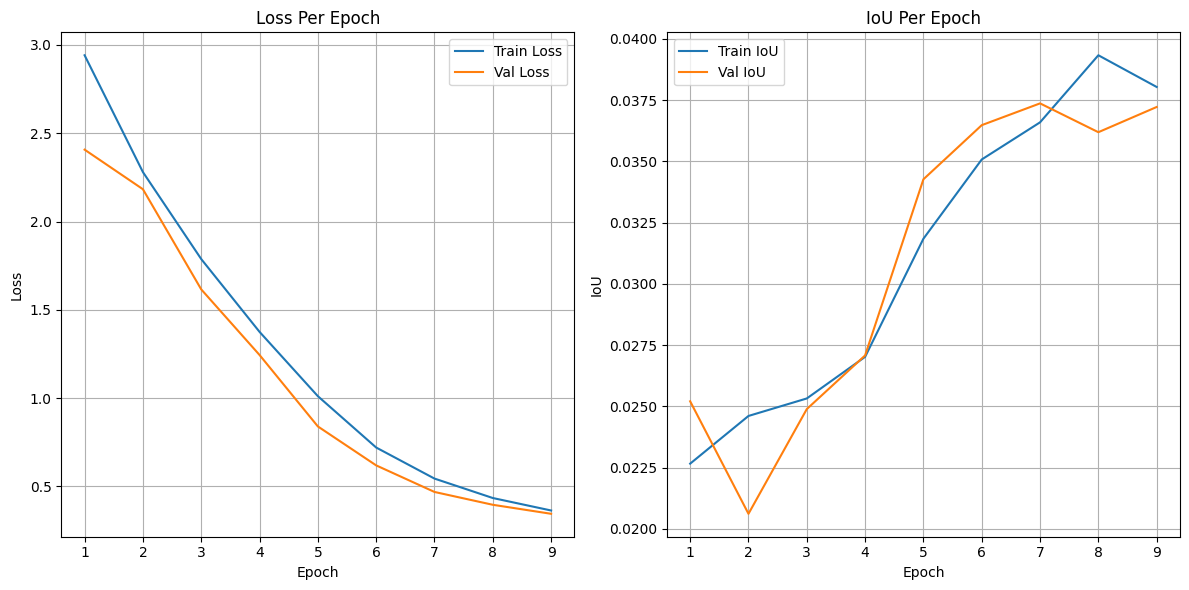

Epoch 10/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.93s/it]

Train Loss: 0.3243, Train IoU: 0.0383 | Val Loss: 0.3135, Val IoU: 0.0385
Model saved as saved_models/UNet_epoch_10.pth
Metrics saved as saved_models/metrics_epoch_10.csv


/kaggle/working/saved_models/UNet_epoch_10.pth

/kaggle/working/saved_models/metrics_epoch_10.csv

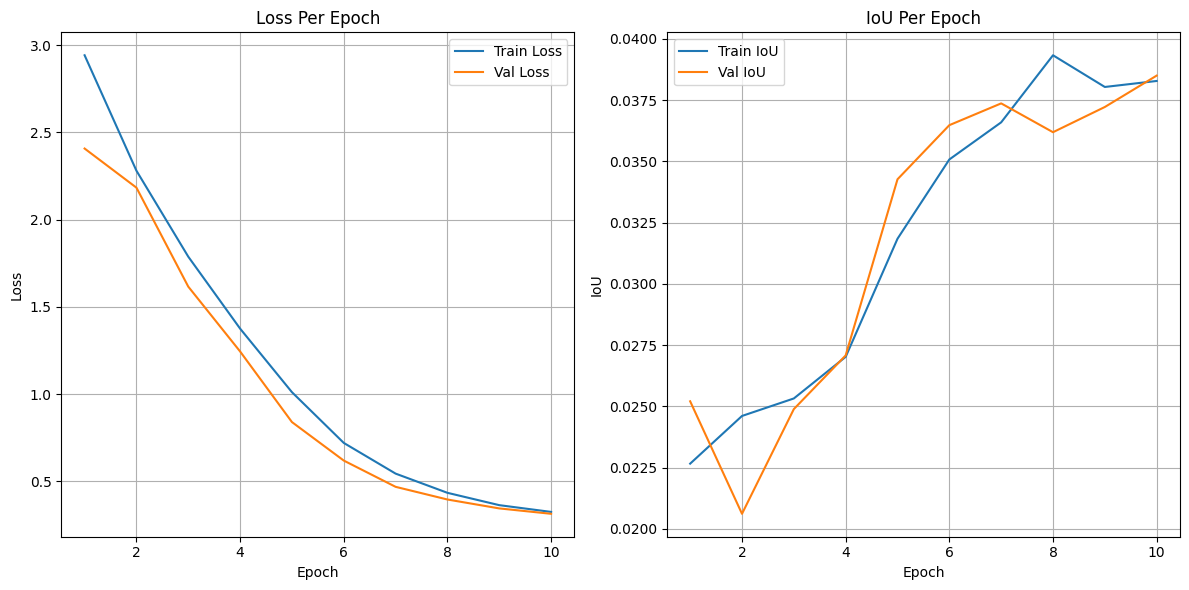

Epoch 11/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.94s/it]

Train Loss: 0.2989, Train IoU: 0.0387 | Val Loss: 0.3095, Val IoU: 0.0378
Model saved as saved_models/UNet_epoch_11.pth
Metrics saved as saved_models/metrics_epoch_11.csv


/kaggle/working/saved_models/UNet_epoch_11.pth

/kaggle/working/saved_models/metrics_epoch_11.csv

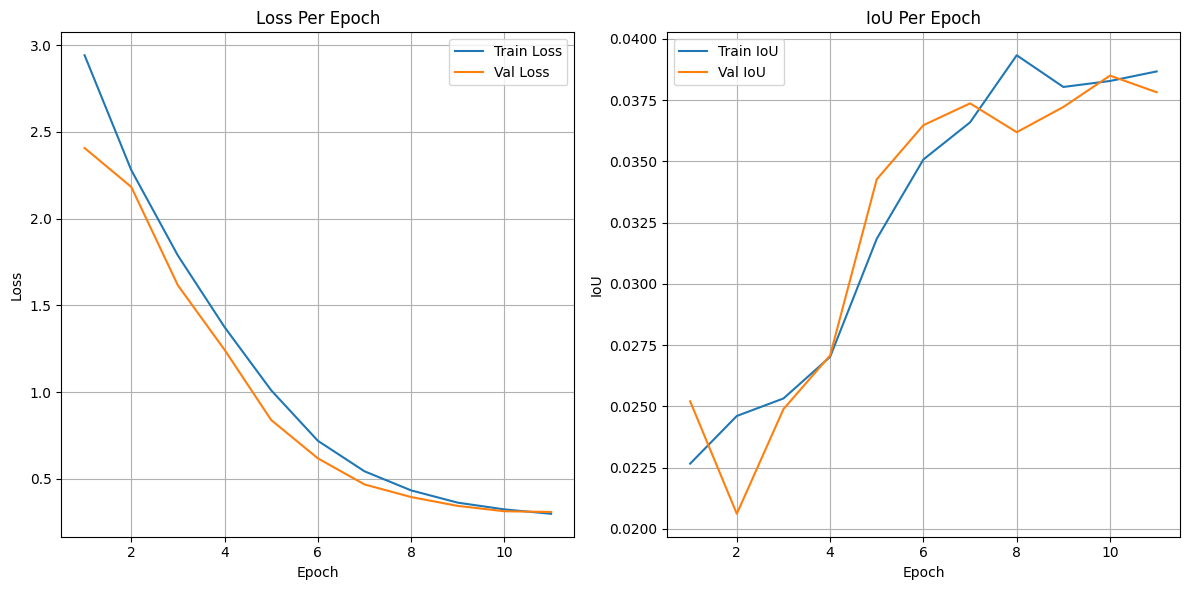

Epoch 12/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.95s/it]

Train Loss: 0.2815, Train IoU: 0.0387 | Val Loss: 0.2642, Val IoU: 0.0393
Model saved as saved_models/UNet_epoch_12.pth
Metrics saved as saved_models/metrics_epoch_12.csv


/kaggle/working/saved_models/UNet_epoch_12.pth

/kaggle/working/saved_models/metrics_epoch_12.csv

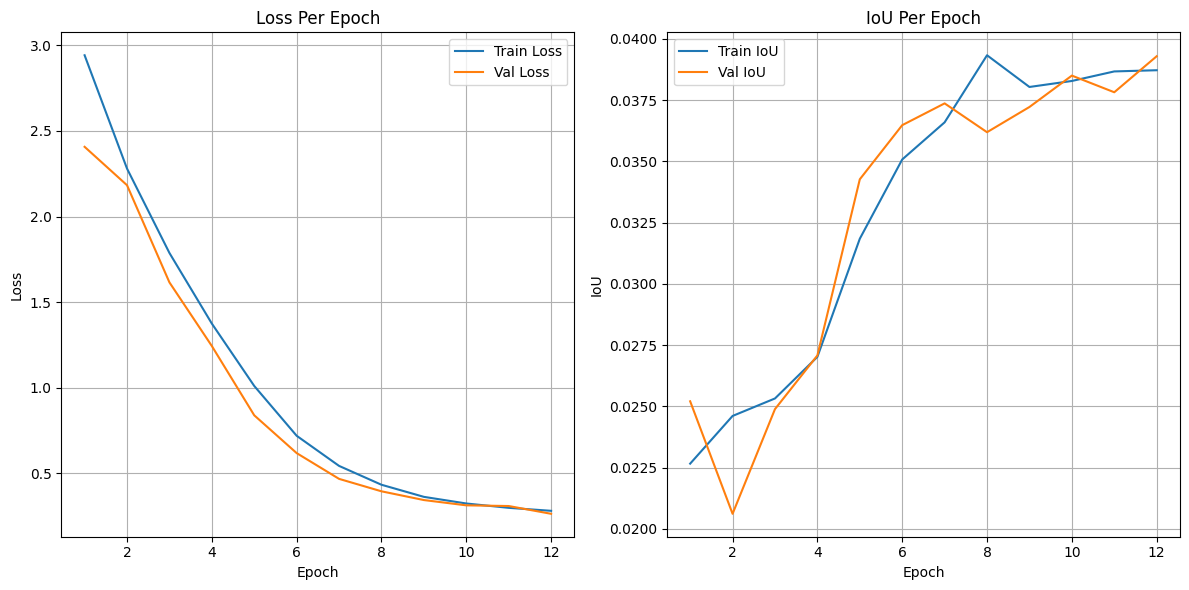

Epoch 13/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.93s/it]

Train Loss: 0.2550, Train IoU: 0.0396 | Val Loss: 0.2667, Val IoU: 0.0390
Model saved as saved_models/UNet_epoch_13.pth
Metrics saved as saved_models/metrics_epoch_13.csv


/kaggle/working/saved_models/UNet_epoch_13.pth

/kaggle/working/saved_models/metrics_epoch_13.csv

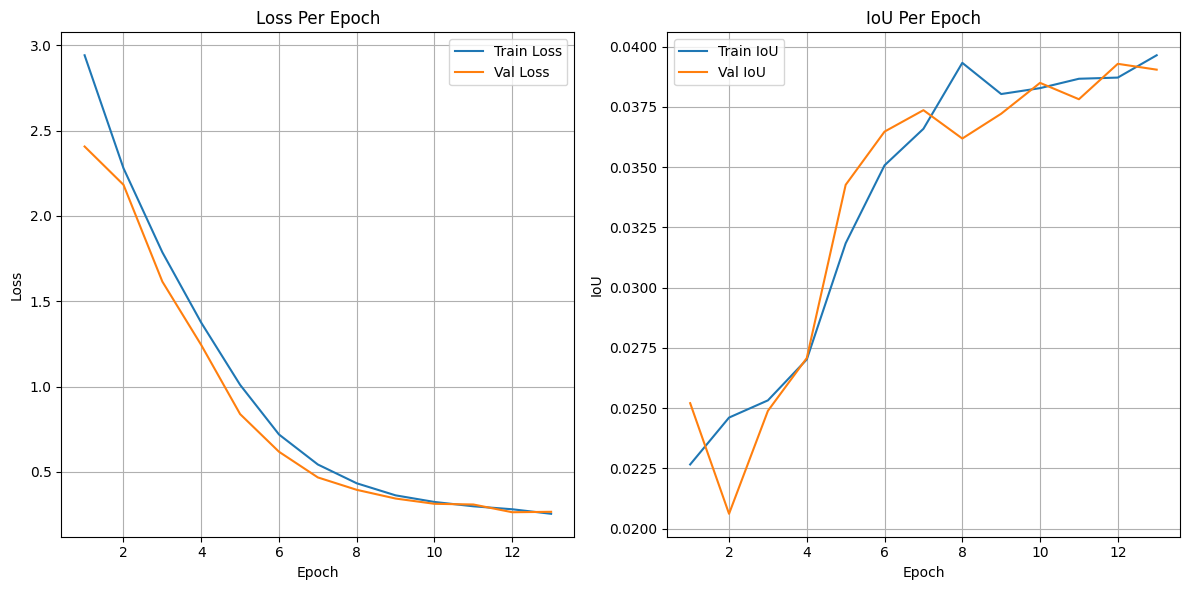

EarlyStopping counter: 1 out of 10
Epoch 14/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.95s/it]

Train Loss: 0.2449, Train IoU: 0.0400 | Val Loss: 0.2482, Val IoU: 0.0394
Model saved as saved_models/UNet_epoch_14.pth
Metrics saved as saved_models/metrics_epoch_14.csv


/kaggle/working/saved_models/UNet_epoch_14.pth

/kaggle/working/saved_models/metrics_epoch_14.csv

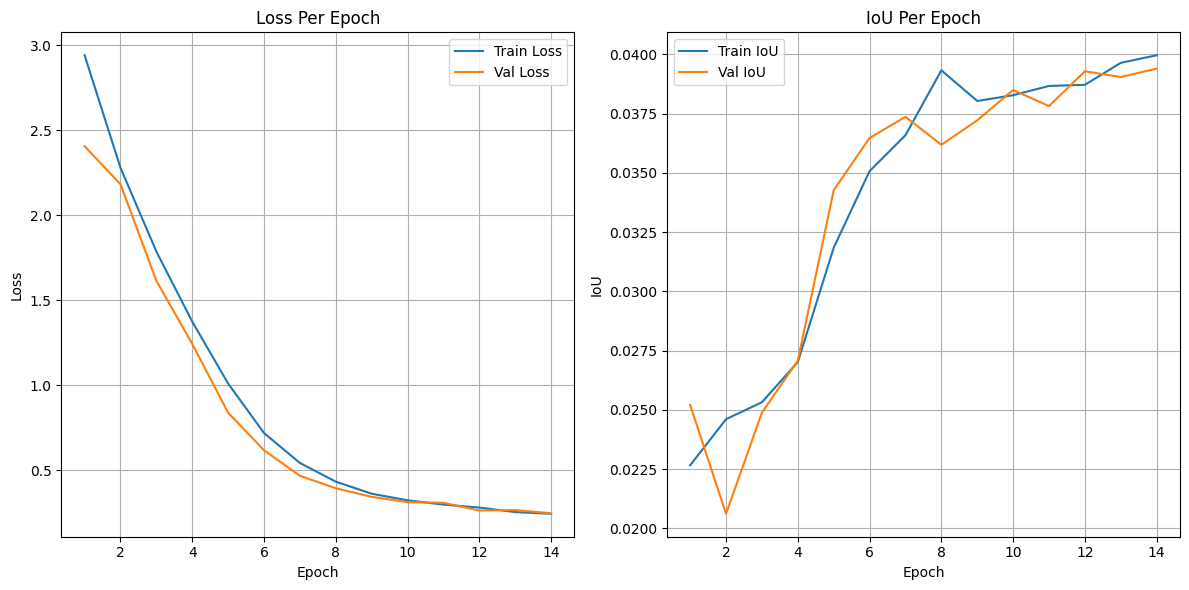

Epoch 15/500


Validation: 100%|██████████| 28/28 [00:55<00:00,  1.98s/it]

Train Loss: 0.2349, Train IoU: 0.0401 | Val Loss: 0.2478, Val IoU: 0.0385
Model saved as saved_models/UNet_epoch_15.pth
Metrics saved as saved_models/metrics_epoch_15.csv


/kaggle/working/saved_models/UNet_epoch_15.pth

/kaggle/working/saved_models/metrics_epoch_15.csv

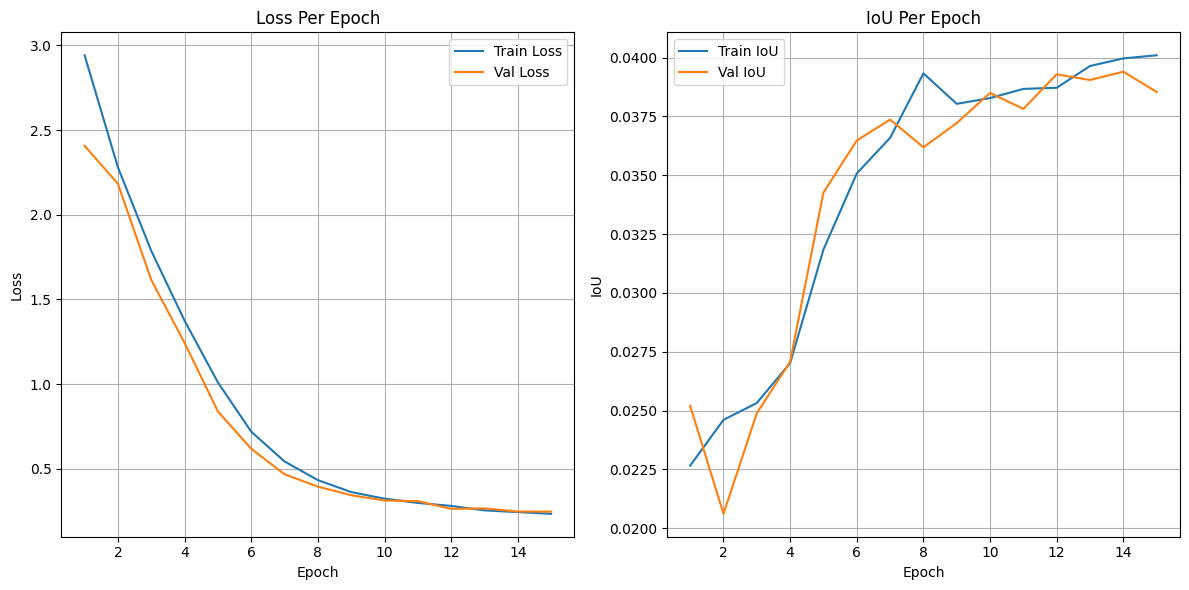

Epoch 16/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.94s/it]

Train Loss: 0.2244, Train IoU: 0.0406 | Val Loss: 0.2287, Val IoU: 0.0393
Model saved as saved_models/UNet_epoch_16.pth
Metrics saved as saved_models/metrics_epoch_16.csv


/kaggle/working/saved_models/UNet_epoch_16.pth

/kaggle/working/saved_models/metrics_epoch_16.csv

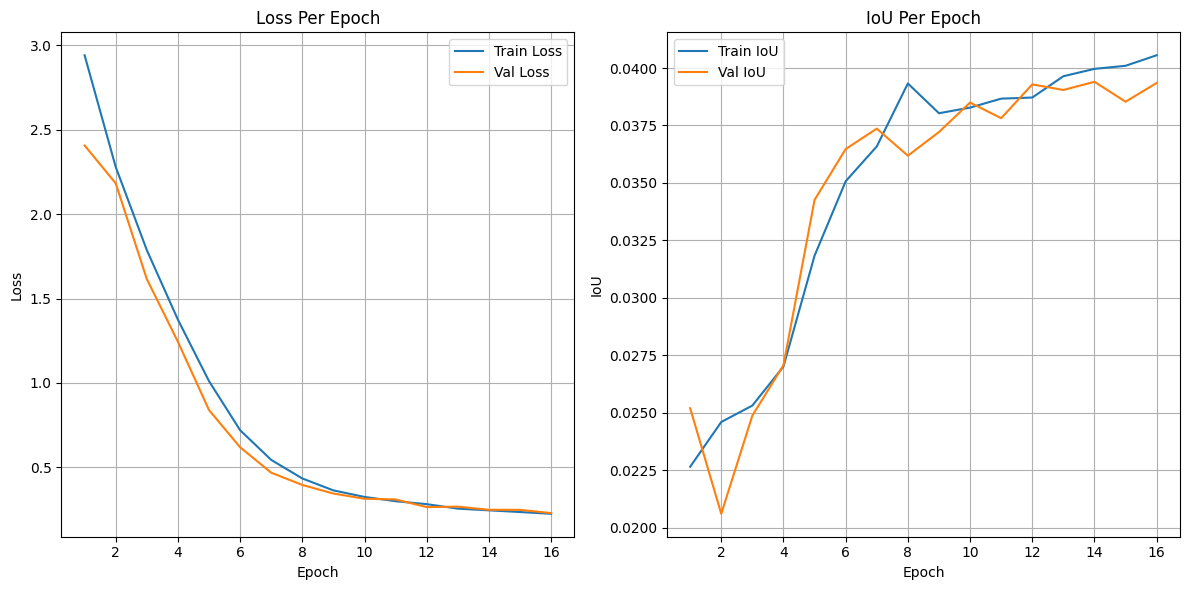

Epoch 17/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.94s/it]

Train Loss: 0.2151, Train IoU: 0.0408 | Val Loss: 0.2320, Val IoU: 0.0387
Model saved as saved_models/UNet_epoch_17.pth
Metrics saved as saved_models/metrics_epoch_17.csv


/kaggle/working/saved_models/UNet_epoch_17.pth

/kaggle/working/saved_models/metrics_epoch_17.csv

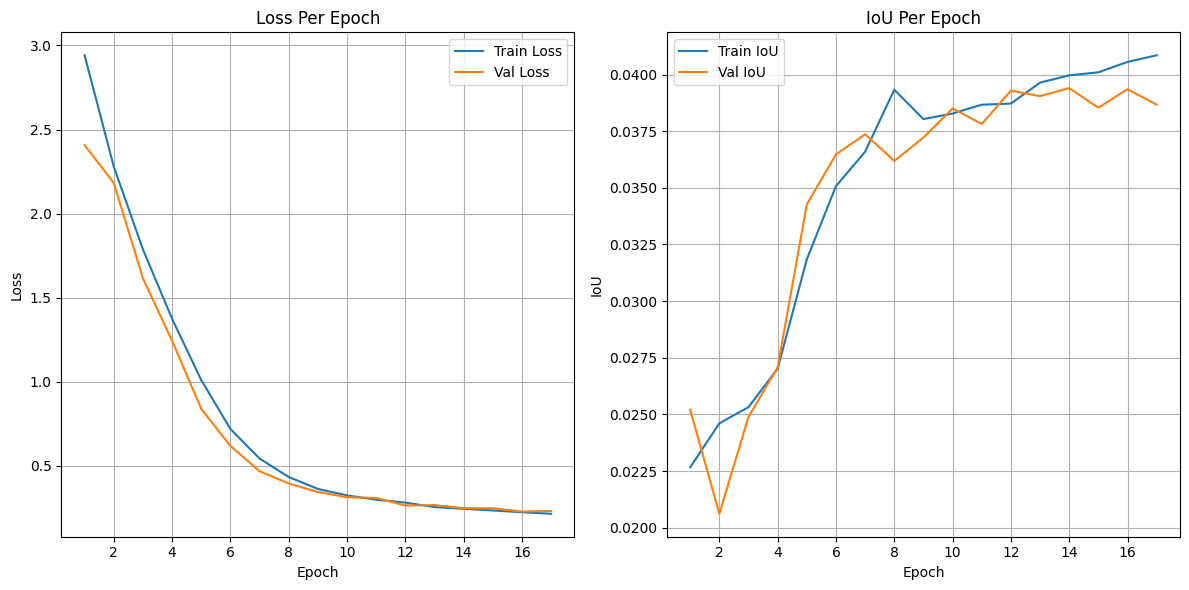

EarlyStopping counter: 1 out of 10
Epoch 18/500


Validation: 100%|██████████| 28/28 [00:53<00:00,  1.92s/it]

Train Loss: 0.1959, Train IoU: 0.0417 | Val Loss: 0.2144, Val IoU: 0.0401
Model saved as saved_models/UNet_epoch_19.pth
Metrics saved as saved_models/metrics_epoch_19.csv


/kaggle/working/saved_models/UNet_epoch_19.pth

/kaggle/working/saved_models/metrics_epoch_19.csv

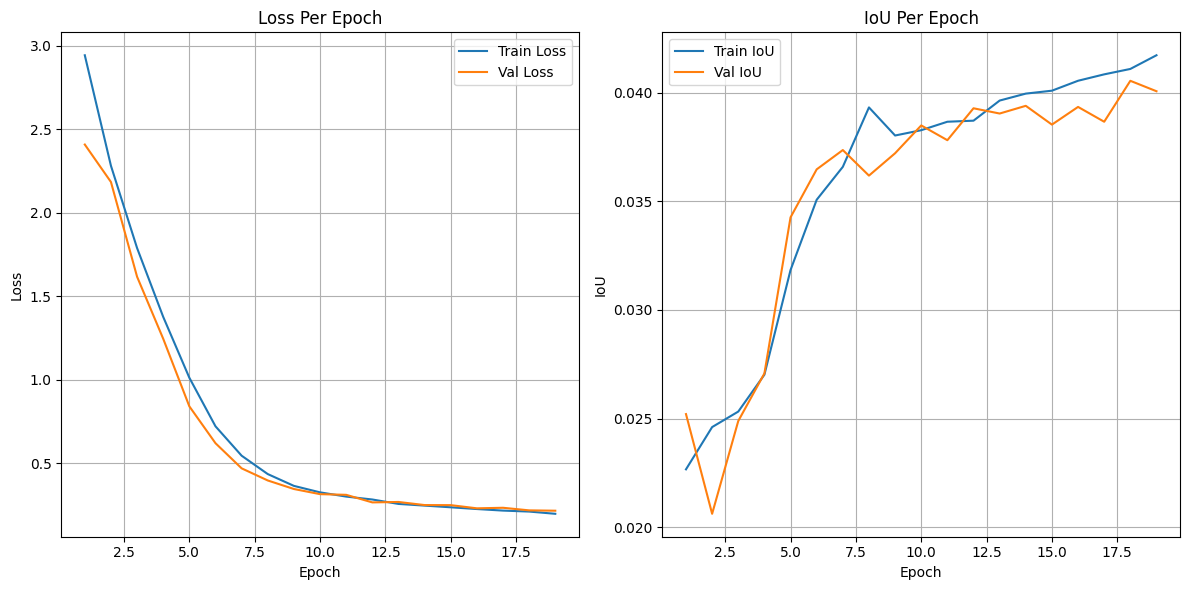

Epoch 20/500


Validation: 100%|██████████| 28/28 [00:53<00:00,  1.92s/it]

Train Loss: 0.1894, Train IoU: 0.0423 | Val Loss: 0.1939, Val IoU: 0.0415
Model saved as saved_models/UNet_epoch_20.pth
Metrics saved as saved_models/metrics_epoch_20.csv


/kaggle/working/saved_models/UNet_epoch_20.pth

/kaggle/working/saved_models/metrics_epoch_20.csv

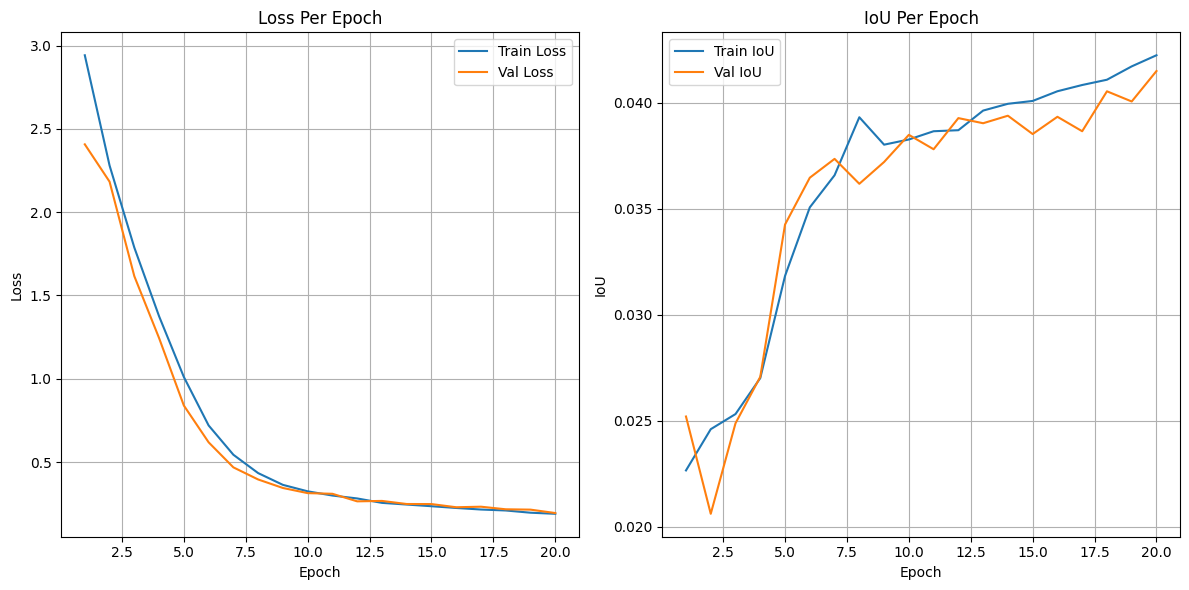

Epoch 21/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.93s/it]

Train Loss: 0.1835, Train IoU: 0.0423 | Val Loss: 0.1922, Val IoU: 0.0415
Model saved as saved_models/UNet_epoch_21.pth
Metrics saved as saved_models/metrics_epoch_21.csv


/kaggle/working/saved_models/UNet_epoch_21.pth

/kaggle/working/saved_models/metrics_epoch_21.csv

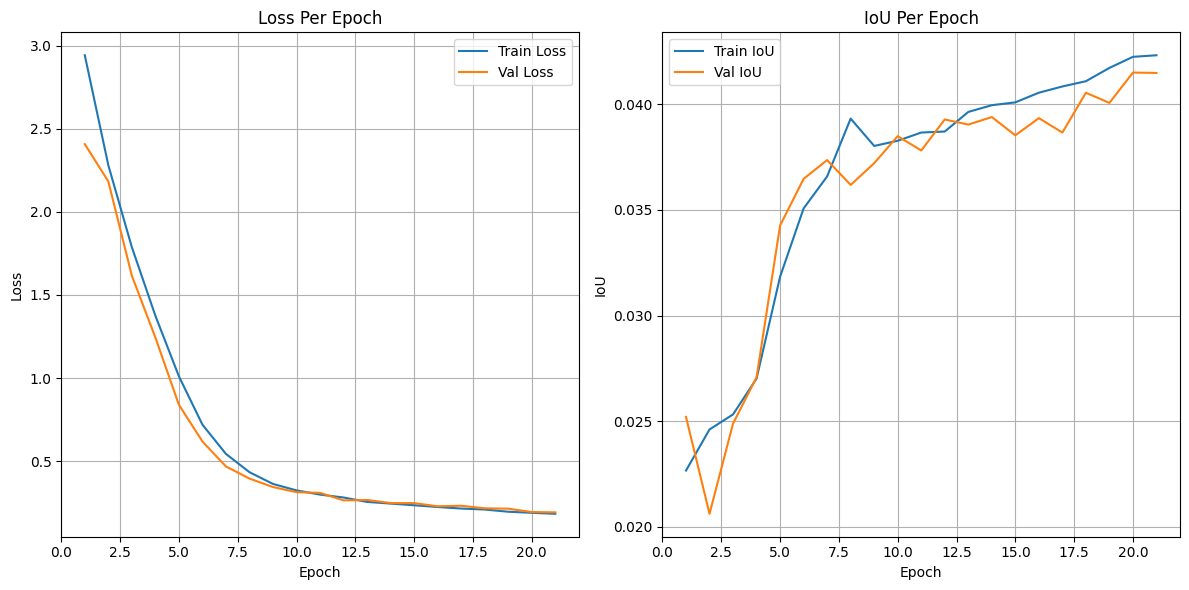

Epoch 22/500


Validation: 100%|██████████| 28/28 [00:53<00:00,  1.91s/it]

Train Loss: 0.1801, Train IoU: 0.0425 | Val Loss: 0.2004, Val IoU: 0.0411
Model saved as saved_models/UNet_epoch_22.pth
Metrics saved as saved_models/metrics_epoch_22.csv


/kaggle/working/saved_models/UNet_epoch_22.pth

/kaggle/working/saved_models/metrics_epoch_22.csv

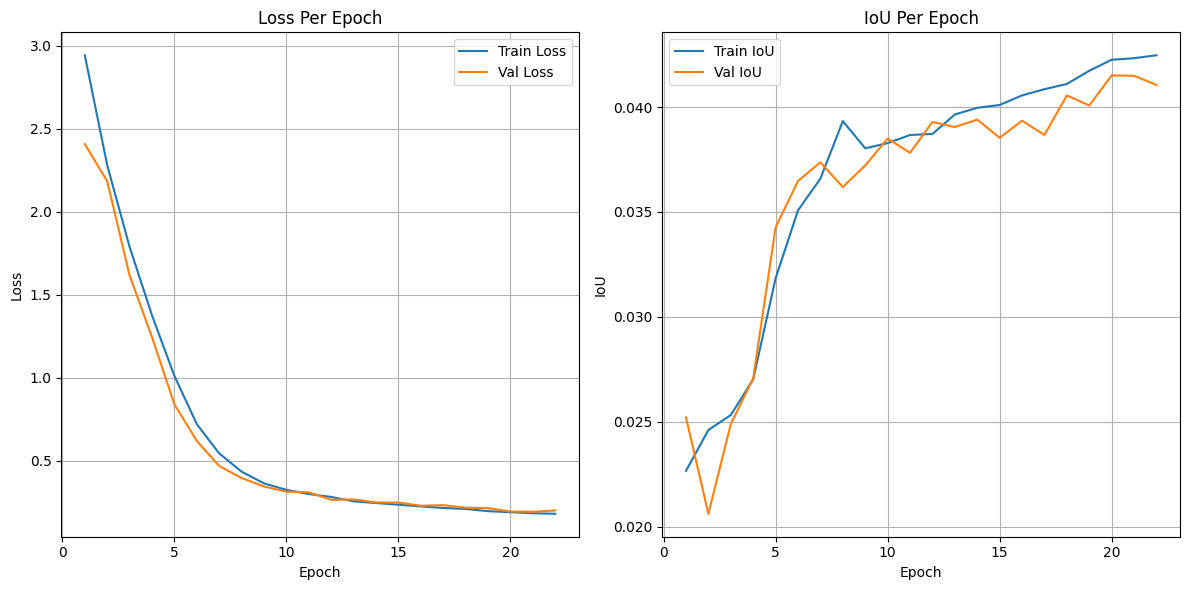

EarlyStopping counter: 1 out of 10
Epoch 23/500


Validation: 100%|██████████| 28/28 [00:53<00:00,  1.92s/it]

Train Loss: 0.1802, Train IoU: 0.0425 | Val Loss: 0.1884, Val IoU: 0.0417
Model saved as saved_models/UNet_epoch_23.pth
Metrics saved as saved_models/metrics_epoch_23.csv


/kaggle/working/saved_models/UNet_epoch_23.pth

/kaggle/working/saved_models/metrics_epoch_23.csv

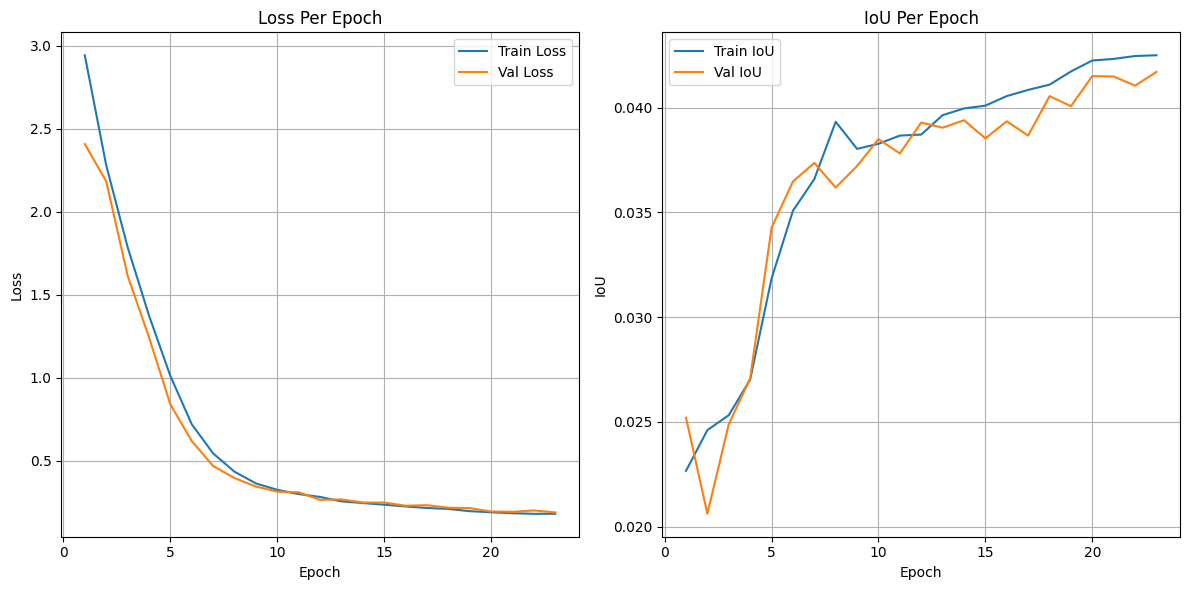

Epoch 24/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.94s/it]

Train Loss: 0.1649, Train IoU: 0.0434 | Val Loss: 0.1931, Val IoU: 0.0413
Model saved as saved_models/UNet_epoch_24.pth
Metrics saved as saved_models/metrics_epoch_24.csv


/kaggle/working/saved_models/UNet_epoch_24.pth

/kaggle/working/saved_models/metrics_epoch_24.csv

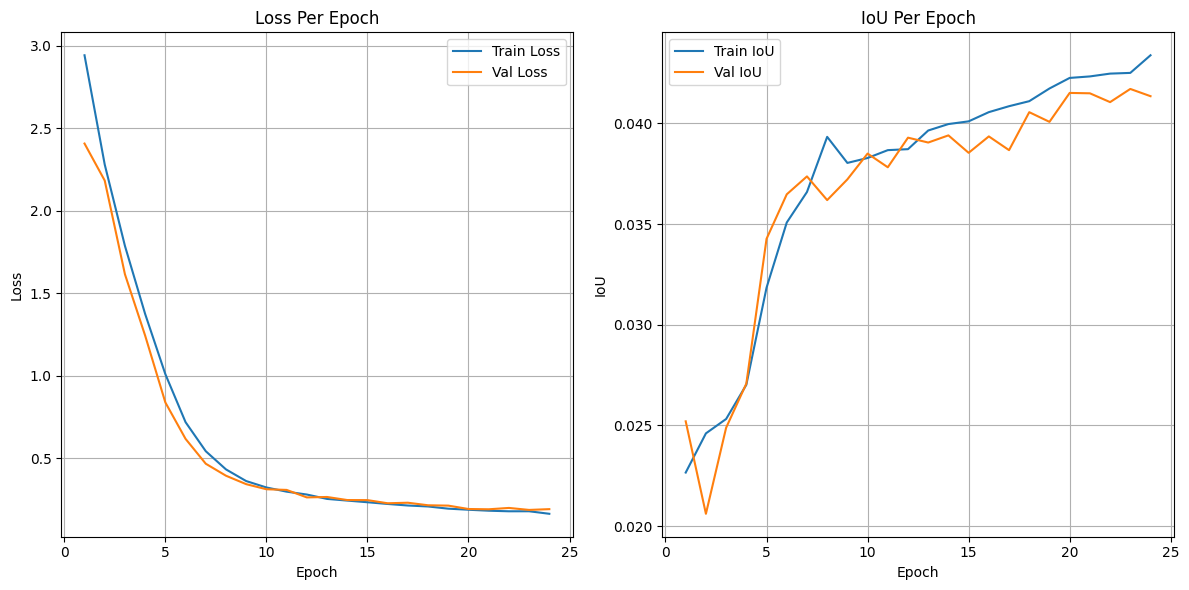

EarlyStopping counter: 1 out of 10
Epoch 25/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.93s/it]

Train Loss: 0.1585, Train IoU: 0.0437 | Val Loss: 0.1953, Val IoU: 0.0413
Model saved as saved_models/UNet_epoch_25.pth
Metrics saved as saved_models/metrics_epoch_25.csv


/kaggle/working/saved_models/UNet_epoch_25.pth

/kaggle/working/saved_models/metrics_epoch_25.csv

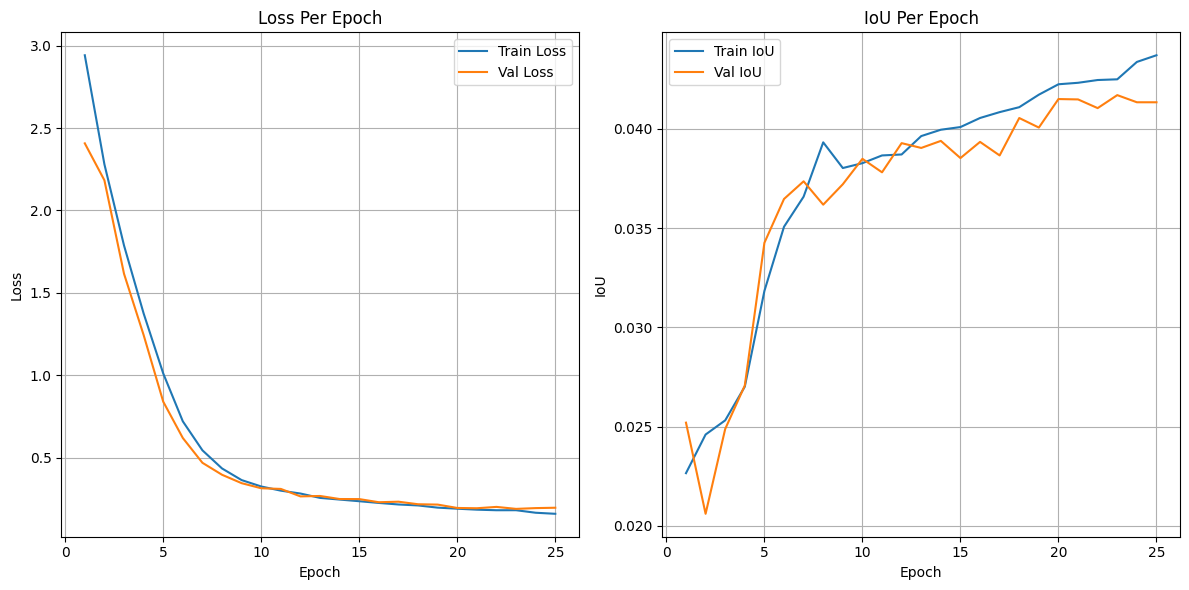

EarlyStopping counter: 2 out of 10
Epoch 26/500


Validation: 100%|██████████| 28/28 [00:53<00:00,  1.92s/it]

Train Loss: 0.1707, Train IoU: 0.0493 | Val Loss: 0.2117, Val IoU: 0.0405
Model saved as saved_models/UNet_epoch_26.pth
Metrics saved as saved_models/metrics_epoch_26.csv


/kaggle/working/saved_models/UNet_epoch_26.pth

/kaggle/working/saved_models/metrics_epoch_26.csv

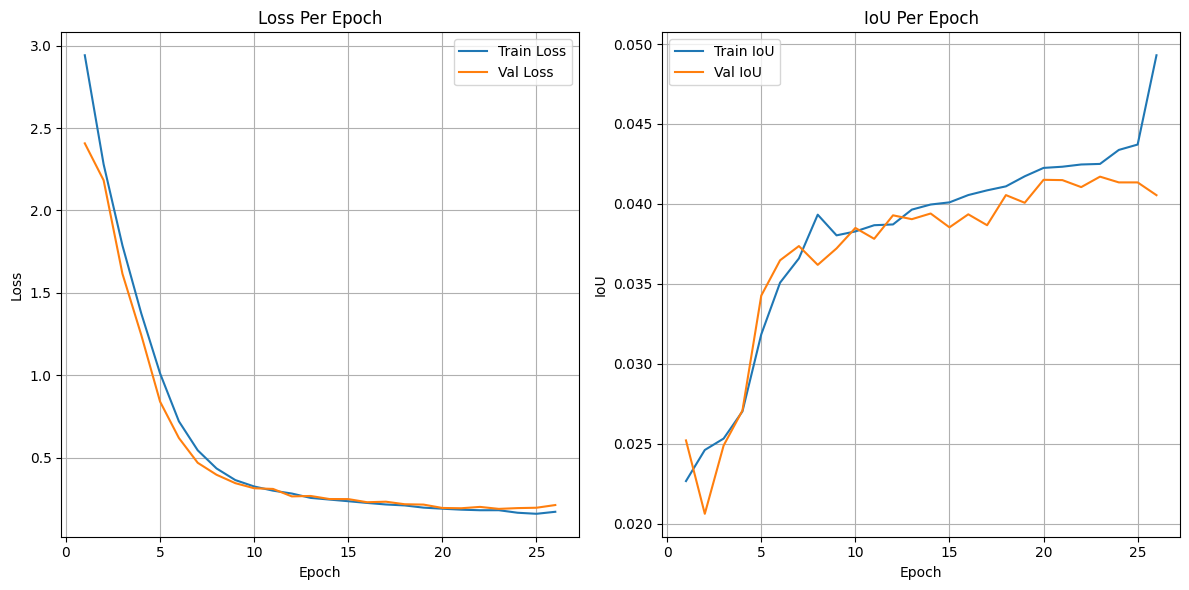

EarlyStopping counter: 3 out of 10
Epoch 27/500


Validation: 100%|██████████| 28/28 [00:53<00:00,  1.92s/it]

Train Loss: 0.1537, Train IoU: 0.0439 | Val Loss: 0.1934, Val IoU: 0.0414
Model saved as saved_models/UNet_epoch_27.pth
Metrics saved as saved_models/metrics_epoch_27.csv


/kaggle/working/saved_models/UNet_epoch_27.pth

/kaggle/working/saved_models/metrics_epoch_27.csv

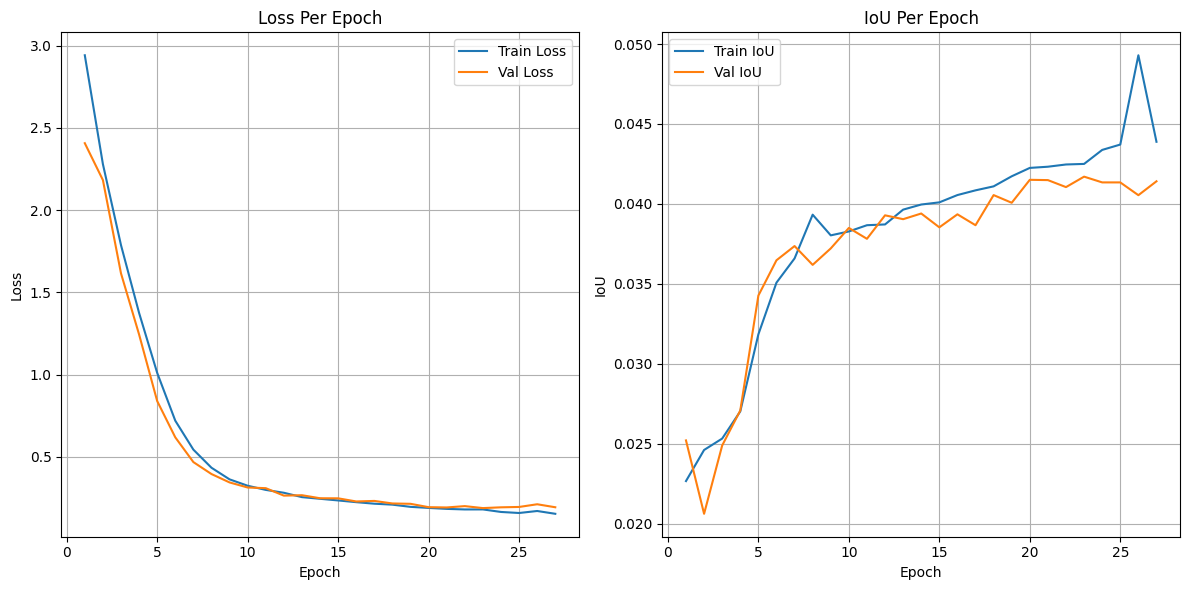

EarlyStopping counter: 4 out of 10
Epoch 28/500


Validation: 100%|██████████| 28/28 [00:53<00:00,  1.91s/it]

Train Loss: 0.1555, Train IoU: 0.0460 | Val Loss: 0.1903, Val IoU: 0.0417
Model saved as saved_models/UNet_epoch_28.pth
Metrics saved as saved_models/metrics_epoch_28.csv


/kaggle/working/saved_models/UNet_epoch_28.pth

/kaggle/working/saved_models/metrics_epoch_28.csv

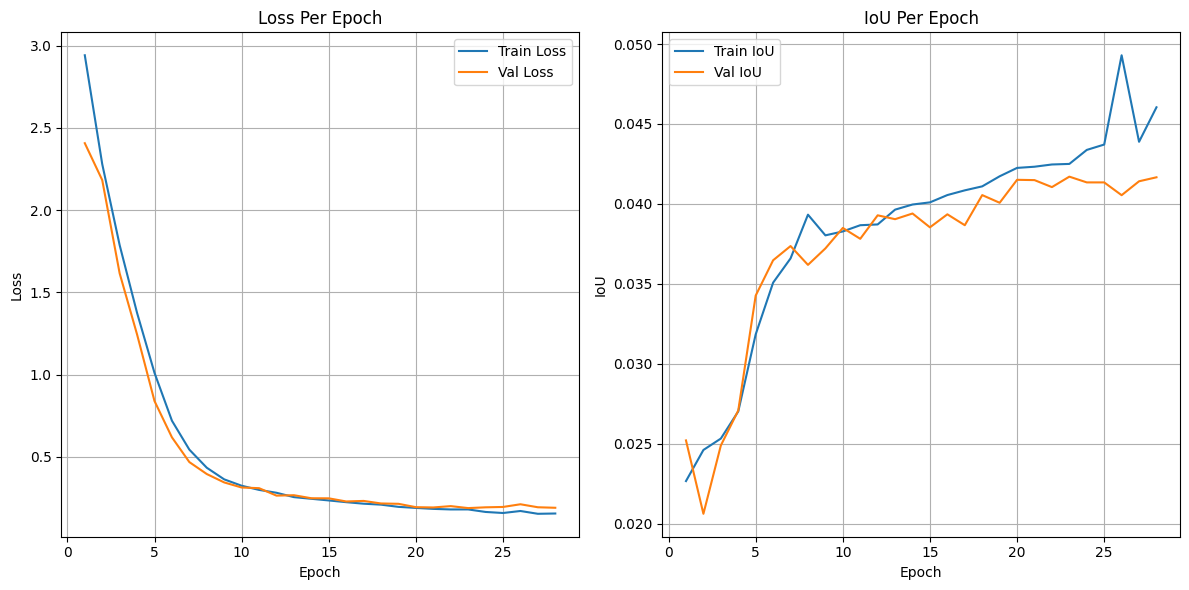

EarlyStopping counter: 5 out of 10
Epoch 29/500


Validation: 100%|██████████| 28/28 [00:55<00:00,  1.97s/it]

Train Loss: 0.1405, Train IoU: 0.0447 | Val Loss: 0.1769, Val IoU: 0.0427
Model saved as saved_models/UNet_epoch_29.pth
Metrics saved as saved_models/metrics_epoch_29.csv


/kaggle/working/saved_models/UNet_epoch_29.pth

/kaggle/working/saved_models/metrics_epoch_29.csv

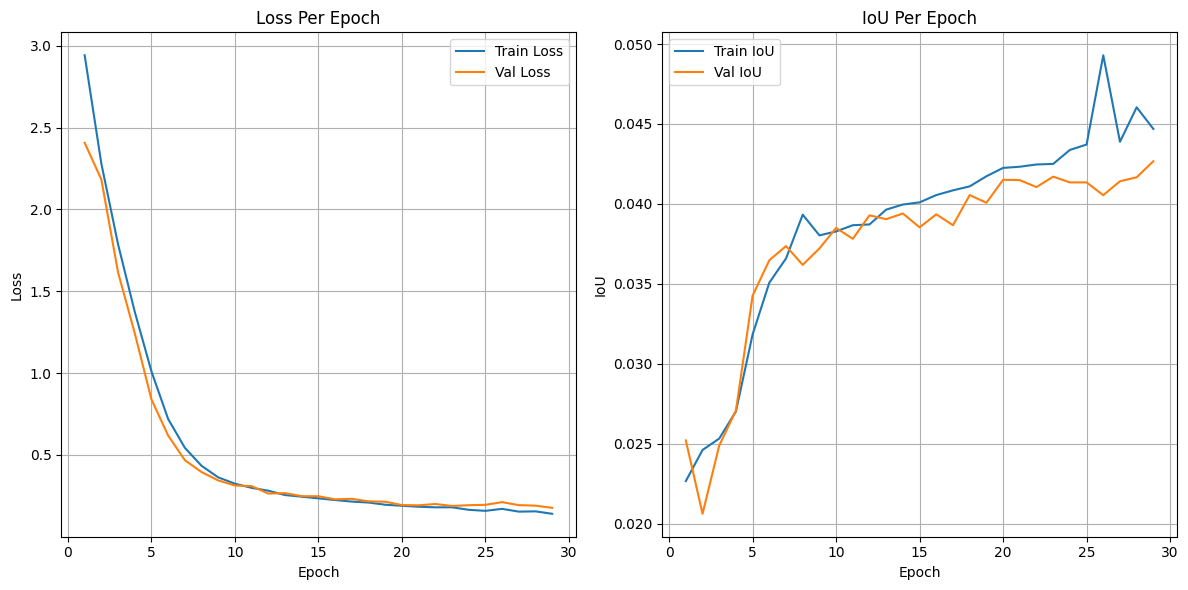

Epoch 30/500


Validation: 100%|██████████| 28/28 [00:53<00:00,  1.92s/it]

Train Loss: 0.1458, Train IoU: 0.0443 | Val Loss: 0.1865, Val IoU: 0.0415
Model saved as saved_models/UNet_epoch_30.pth
Metrics saved as saved_models/metrics_epoch_30.csv


/kaggle/working/saved_models/UNet_epoch_30.pth

/kaggle/working/saved_models/metrics_epoch_30.csv

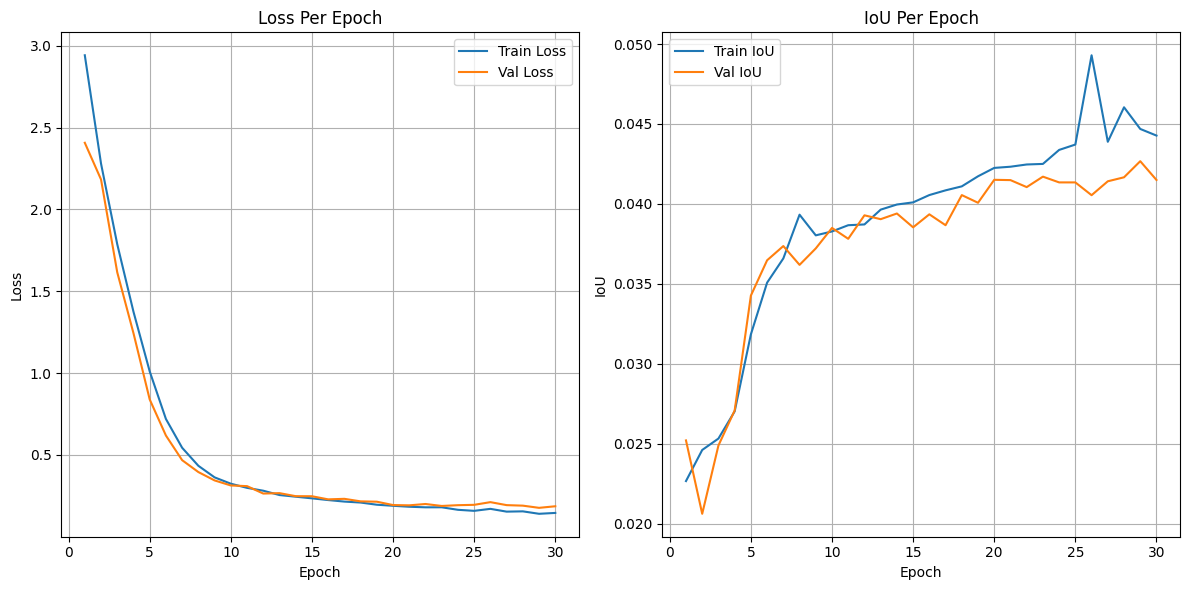

EarlyStopping counter: 1 out of 10
Epoch 31/500


Validation: 100%|██████████| 28/28 [00:55<00:00,  1.98s/it]

Train Loss: 0.1346, Train IoU: 0.0450 | Val Loss: 0.1680, Val IoU: 0.0428
Model saved as saved_models/UNet_epoch_31.pth
Metrics saved as saved_models/metrics_epoch_31.csv


/kaggle/working/saved_models/UNet_epoch_31.pth

/kaggle/working/saved_models/metrics_epoch_31.csv

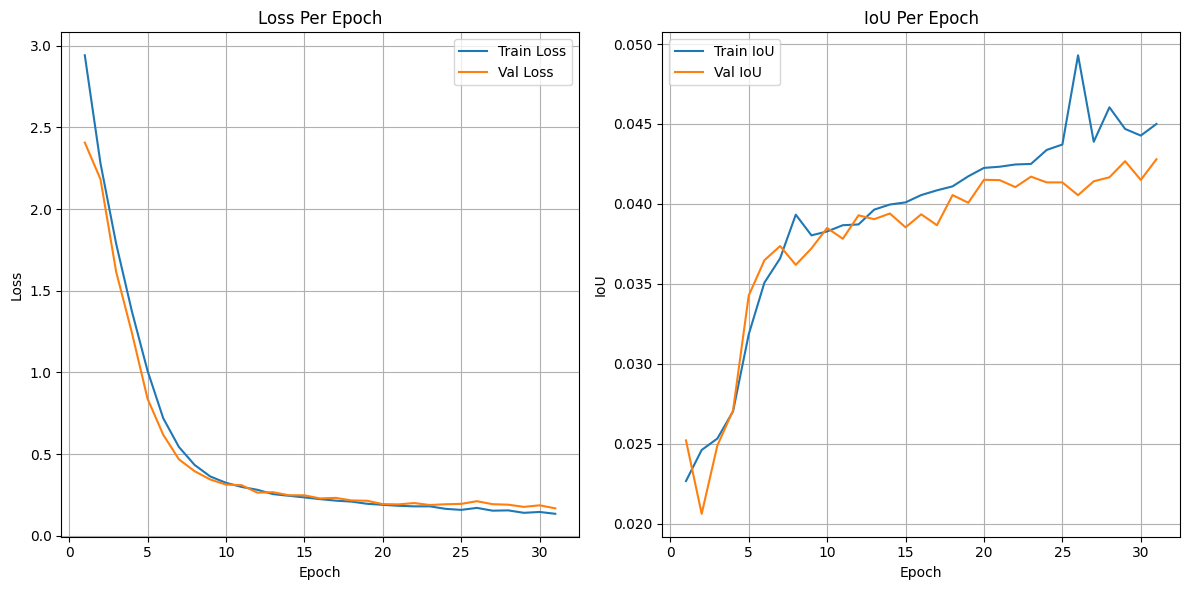

Epoch 32/500


Validation: 100%|██████████| 28/28 [00:54<00:00,  1.93s/it]

Train Loss: 0.1302, Train IoU: 0.0452 | Val Loss: 0.2263, Val IoU: 0.0402
Model saved as saved_models/UNet_epoch_32.pth
Metrics saved as saved_models/metrics_epoch_32.csv


/kaggle/working/saved_models/UNet_epoch_32.pth

/kaggle/working/saved_models/metrics_epoch_32.csv

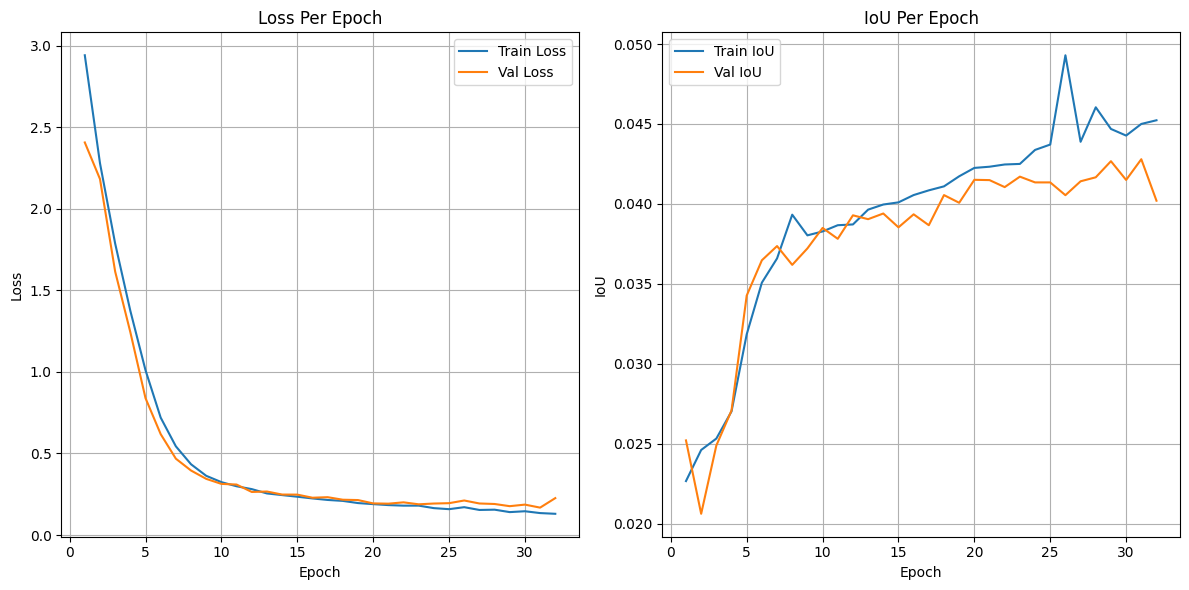

EarlyStopping counter: 1 out of 10
Epoch 33/500


Training:  54%|█████▍    | 70/129 [02:55<02:29,  2.54s/it]

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from IPython.display import FileLink


def compute_iou(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    iou_per_class = []
    for cls in range(num_classes):
        intersection = torch.logical_and(target == cls, pred == cls).sum().item()
        union = torch.logical_or(target == cls, pred == cls).sum().item()
        if union == 0:
            iou_per_class.append(float("nan"))
        else:
            iou_per_class.append(intersection / union)
    return np.nanmean(iou_per_class)


class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = np.Inf
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


def one_hot_encode(masks, num_classes):
    one_hot_masks = torch.zeros(
        masks.size(0), num_classes, masks.size(1), masks.size(2)
    ).to(masks.device)
    for i in range(num_classes):
        one_hot_masks[:, i, :, :] = (masks == i).float()
    return one_hot_masks


def save_model_and_metrics(model, epoch, train_losses, val_losses, train_ious, val_ious, save_dir="saved_models"):
    # Save model weights
    model_save_path = os.path.join(save_dir, f"UNet_epoch_{epoch + 1}.pth")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved as {model_save_path}")

    # Save performance metrics to CSV
    metrics = {
        'epoch': range(1, len(train_losses) + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_iou': train_ious,
        'val_iou': val_ious
    }
    df = pd.DataFrame(metrics)
    csv_save_path = os.path.join(save_dir, f"metrics_epoch_{epoch + 1}.csv")
    df.to_csv(csv_save_path, index=False)
    print(f"Metrics saved as {csv_save_path}")

    # Generate download links for Kaggle
    display(FileLink(model_save_path))
    display(FileLink(csv_save_path))


def train_model_with_visualization(
    model, train_loader, val_loader, device, criterion, optimizer, scheduler, n_epochs, patience, num_classes
):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    train_losses, val_losses, train_ious, val_ious = [], [], [], []
    
    save_dir = "saved_models"  # Directory to save models and metrics
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        model.train()
        train_loss, train_iou = 0.0, 0.0
        for images, masks in tqdm(train_loader, desc="Training"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_iou += compute_iou(outputs, masks, num_classes)

        train_losses.append(train_loss / len(train_loader))
        train_ious.append(train_iou / len(train_loader))

        model.eval()
        val_loss, val_iou = 0.0, 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validation"):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                val_iou += compute_iou(outputs, masks, num_classes)

        val_losses.append(val_loss / len(val_loader))
        val_ious.append(val_iou / len(val_loader))

        print(
            f"Train Loss: {train_losses[-1]:.4f}, Train IoU: {train_ious[-1]:.4f} | "
            f"Val Loss: {val_losses[-1]:.4f}, Val IoU: {val_ious[-1]:.4f}"
        )

        # Save model and metrics after every epoch
        save_model_and_metrics(model, epoch, train_losses, val_losses, train_ious, val_ious, save_dir)

        # Plot and save visualizations
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), train_losses, label="Train Loss")
        plt.plot(range(1, epoch + 2), val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Per Epoch")
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), train_ious, label="Train IoU")
        plt.plot(range(1, epoch + 2), val_ious, label="Val IoU")
        plt.xlabel("Epoch")
        plt.ylabel("IoU")
        plt.legend()
        plt.title("IoU Per Epoch")
        plt.grid()

        plt.tight_layout()
        plt.savefig(f"epoch_{epoch + 1}_plot.png", dpi=300)
        plt.show()

        scheduler.step(val_losses[-1])
        early_stopping(val_losses[-1])

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    return model, train_losses, val_losses, train_ious, val_ious


def initialize_and_train(model, train_loader, val_loader, device, n_epochs=500, patience=10, num_classes=39):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=5, verbose=True
    )

    return train_model_with_visualization(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        n_epochs=n_epochs,
        patience=patience,
        num_classes=num_classes,
    )


def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss", color="blue")
    plt.plot(epochs, val_losses, label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.tight_layout()  
    plt.title(f"Training and Validation Loss Over {len(train_losses)} Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


device = "cuda" if torch.cuda.is_available() else "cpu"

if __name__ == "__main__":
    model = UNet(n_channels=3, n_classes=39).to(device)

    trained_model, train_losses, val_losses, train_ious, val_ious = initialize_and_train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        n_epochs=500,
        patience=10,
        num_classes=39
    )
    
    plot_losses(train_losses, val_losses)
